In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-15 15:40:11.163792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-30(ii) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/D-30/Device-30(ii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[-0.09375  +0.09375j   -0.0546875-0.015625j   0.0078125+0.015625j  ...
  0.0390625-0.046875j   0.0078125-0.0078125j -0.0078125+0.03125j  ]
2048
82787
(2048, 82787)
[0.02935637 0.01689323 0.00528763 ... 0.00509753 0.00603779 0.0169532 ]
0
(10000, 2048)
(10000,)
[0.03125  -0.015625j  0.0546875-0.0546875j 0.0703125-0.0625j    ...
 0.0703125-0.0234375j 0.0078125+0.0078125j 0.09375  +0.j       ]
2048
81339
(2048, 81339)
[0.02924517 0.01813177 0.00796105 ... 0.00768866 0.00720287 0.01787682]
1
(20000, 2048)
(20000,)
[-0.0234375-0.1015625j  0.03125  -0.015625j   0.015625 +0.j        ...
  0.0546875-0.0234375j  0.0703125+0.0234375j -0.09375  -0.046875j ]
2048
84012
(2048, 84012)
[0.02862767 0.01639104 0.00558128 ... 0.00523017 0.00532019 0.01678962]
2
(30000, 2048)
(30000,)
[0.       -0.0234375j 0.0234375-0.015625j  0.0234375-0.0234375j ...
 0.1640625+0.1171875j 0.0625   +0.1875j    0.015625 +0.09375j  ]
2048
85799
(2048, 85799)
[0.0286698  0.01669605 0.00512103 ... 0.00549245 0.0053625  0.017

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-30(ii) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-03-11 19:56:58.371368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.5609 - accuracy: 0.1129
test loss, test acc: [5.560884475708008, 0.11291249841451645]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[5 5 5 ... 2 2 2]
5
[[   3    0 2937   66   58 6785  143    8]
 [   0    7 8637  727   18  603    3    5]
 [  22    1 2091    6  163 7675   39    3]
 [1986    0  748    0 3421 3837    8    0]
 [   0    0 5007   84   72 4466  335   36]
 [ 139    0 1948    3 1075 6768   66    1]
 [ 236    0 1262    2 1116 7339   45    0]
 [  94    0 6560  577  378 2312   32   47]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.88      0.00      0.00     10000
           2       0.07      0.21      0.11     10000
           3       0.00      0.00      0.00     10000
           4       0.01      0.01      0.01     10000
           5       0.17      0.68      0.27     10000
           6       0.07      0.00      0.01     10000
           7       0.47      0.00      0.01     10000

    accuracy                           0.11     80000
   macro avg       0.21      0.11   

Test Accuracy:0.1129125


Text(0.5, 1.0, 'Accuracy:0.113')

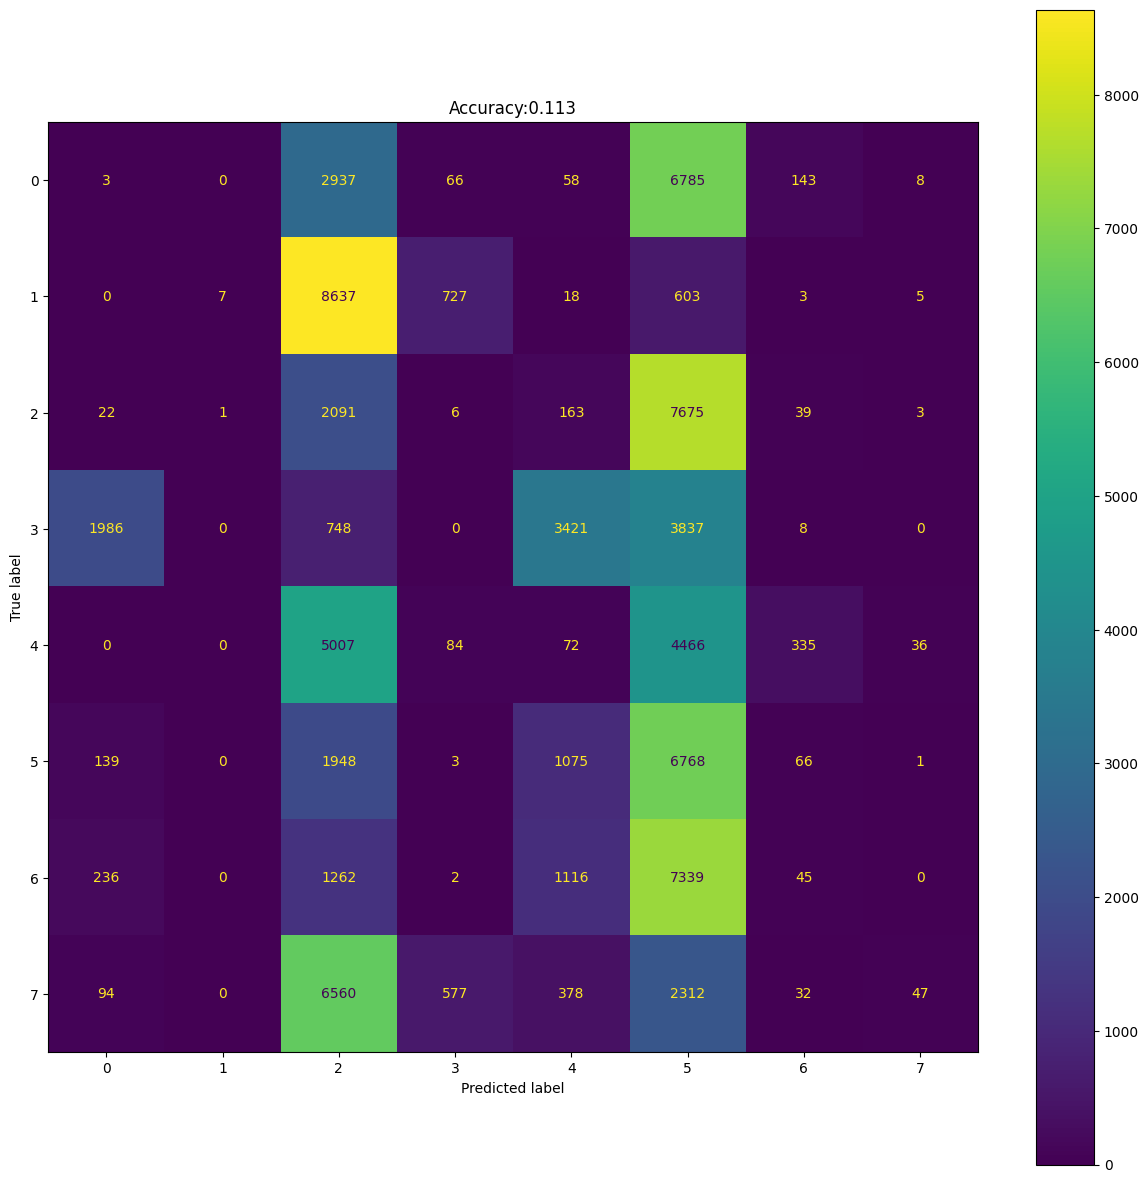

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

Nordic Device-25(i) model to Nordic Device-30(i) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.6186 - accuracy: 0.2045
Epoch 2/30
2500/2500 [==============================] - 9s 3ms/step - loss: 1.6734 - accuracy: 0.3573
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.4923 - accuracy: 0.4238
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.3982 - accuracy: 0.4607
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.3353 - accuracy: 0.4872
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2897 - accuracy: 0.5076
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2546 - accuracy: 0.5241
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2274 - accuracy: 0.5357
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.2051 - accuracy: 0.5463
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.18

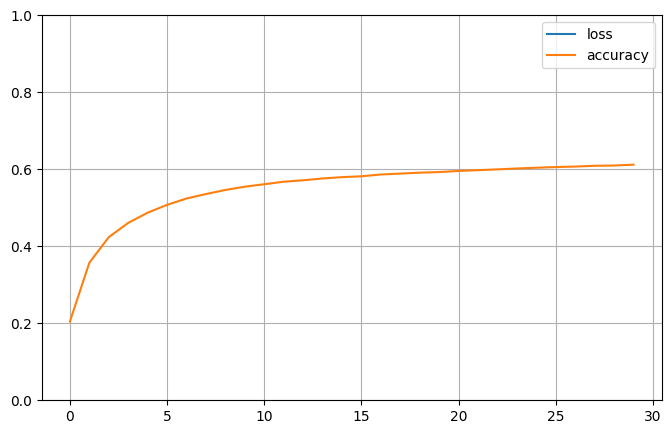

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.0377 - accuracy: 0.6130
test loss, test acc: [1.0376938581466675, 0.6129624843597412]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 7 7 7]
0
[[5659  388  877    1 2287  319   20  449]
 [ 149 8960   42    1  191    7    8  642]
 [ 965  115 5015  221  806 1518  800  560]
 [   2    3  127 8555    3  448  836   26]
 [2219  354  675    8 5937  268   27  512]
 [ 238   62 2208 1221  328 3855 1597  491]
 [  87   29 1539 2161  193 1623 4085  283]
 [ 296  704  705   59  519  213  533 6971]]
              precision    recall  f1-score   support

           0       0.59      0.57      0.58     10000
           1       0.84      0.90      0.87     10000
           2       0.45      0.50      0.47     10000
           3       0.70      0.86      0.77     10000
           4       0.58      0.59      0.59     10000
           5       0.47      0.39      0.42     10000
           6       0.52      0.41      0.46     10000
           7       0.70      0.70      0.70     10000

    accuracy                           0.61     80000
   macro avg       0.61      0.61  

Test Accuracy:0.6129625


Text(0.5, 1.0, 'Accuracy:0.613')

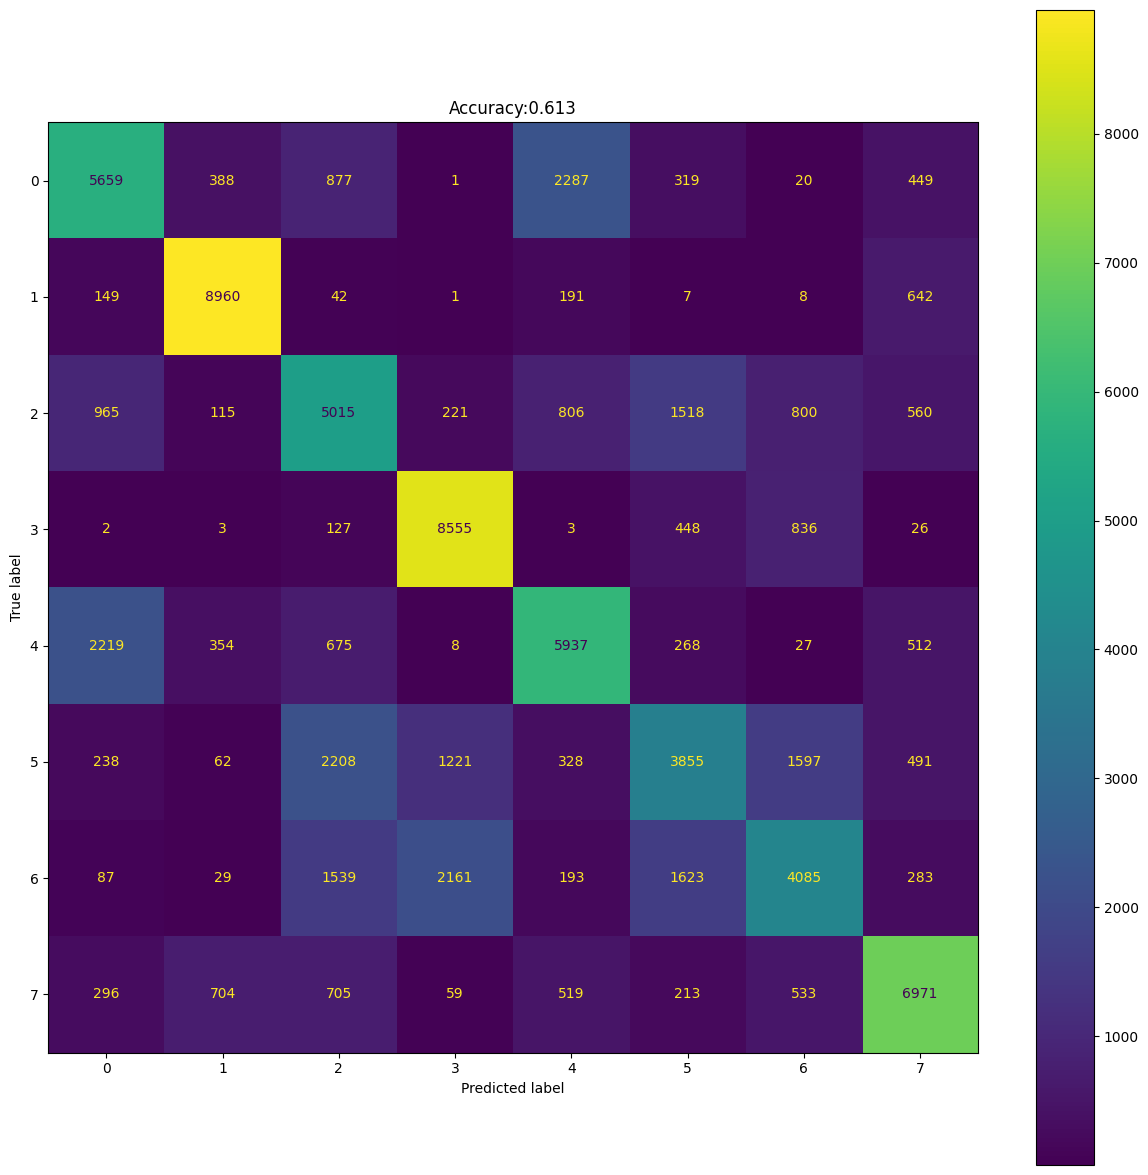

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-25(ii) model to Nordic Device-30(ii) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 7.6653 - accuracy: 0.1226
test loss, test acc: [7.665309429168701, 0.1225999966263771]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 5 ... 5 6 5]
5
[[  17   19 2251    0    0 6259 1452    2]
 [   4    1 4286    6    2 2938 2122  641]
 [ 410    5 3140    0    4 6238  177   26]
 [6675    0 1416    0  247 1487    0  175]
 [  14    0 4015    0    0 4917 1051    3]
 [ 441    1 3241    0   55 6205   19   38]
 [2461    0 1877    0  110 5504    9   39]
 [  37    0 3859    1  162 3559 1946  436]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.04      0.00      0.00     10000
           2       0.13      0.31      0.18     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.17      0.62      0.26     10000
           6       0.00      0.00      0.00     10000
           7       0.32      0.04      0.08     10000

    accuracy                           0.12     80000
   macro avg       0.08      0.12  

Test Accuracy:0.1226


Text(0.5, 1.0, 'Accuracy:0.123')

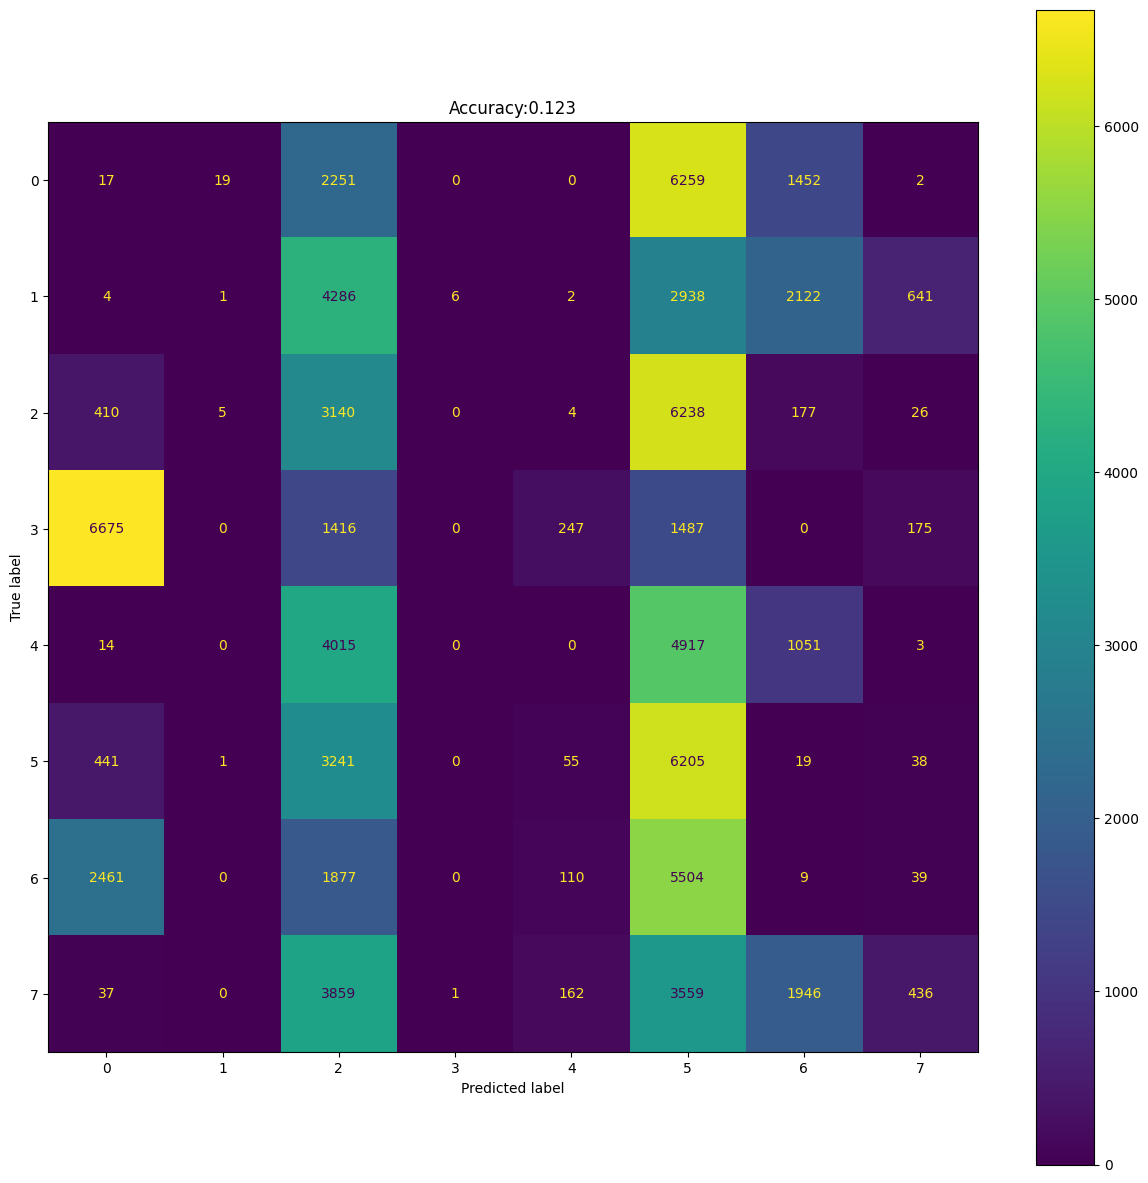

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.7541 - accuracy: 0.1925
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.5672 - accuracy: 0.3505
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3657 - accuracy: 0.4467
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2790 - accuracy: 0.5075
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2316 - accuracy: 0.5303
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.2001 - accuracy: 0.5419
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1766 - accuracy: 0.5494
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.1578 - accuracy: 0.5575
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.1418 - accuracy: 0.5633
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss

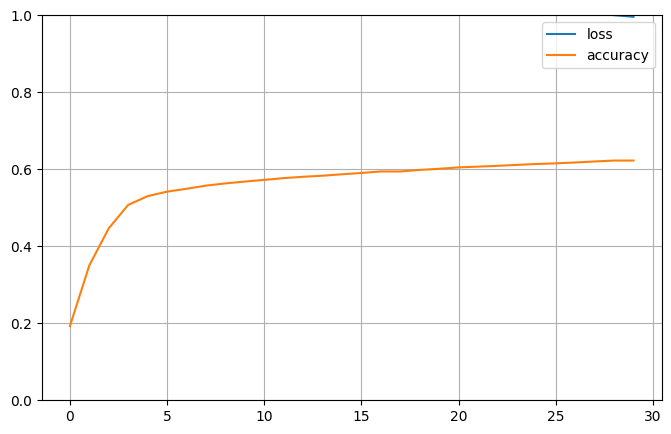

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 9s 4ms/step - loss: 0.9923 - accuracy: 0.6257
test loss, test acc: [0.9922879934310913, 0.625712513923645]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[6 0 2 ... 7 7 0]
6
[[5861  108  820    1 2134  372   71  633]
 [  51 9651   57    7   14   82    4  134]
 [ 923   57 4811  226  553 1979  969  482]
 [   0    0  257 8287    1  280 1140   35]
 [2445  103  738    4 4995  568   71 1076]
 [ 292   56 2334  448  310 4763 1285  512]
 [  81   12 1541 2101   93 1745 4322  105]
 [ 641  330  174  377  910  176   25 7367]]
              precision    recall  f1-score   support

           0       0.57      0.59      0.58     10000
           1       0.94      0.97      0.95     10000
           2       0.45      0.48      0.46     10000
           3       0.72      0.83      0.77     10000
           4       0.55      0.50      0.53     10000
           5       0.48      0.48      0.48     10000
           6       0.55      0.43      0.48     10000
           7       0.71      0.74      0.72     10000

    accuracy                           0.63     80000
   macro avg       0.62      0.63   

Test Accuracy:0.6257125


Text(0.5, 1.0, 'Accuracy:0.626')

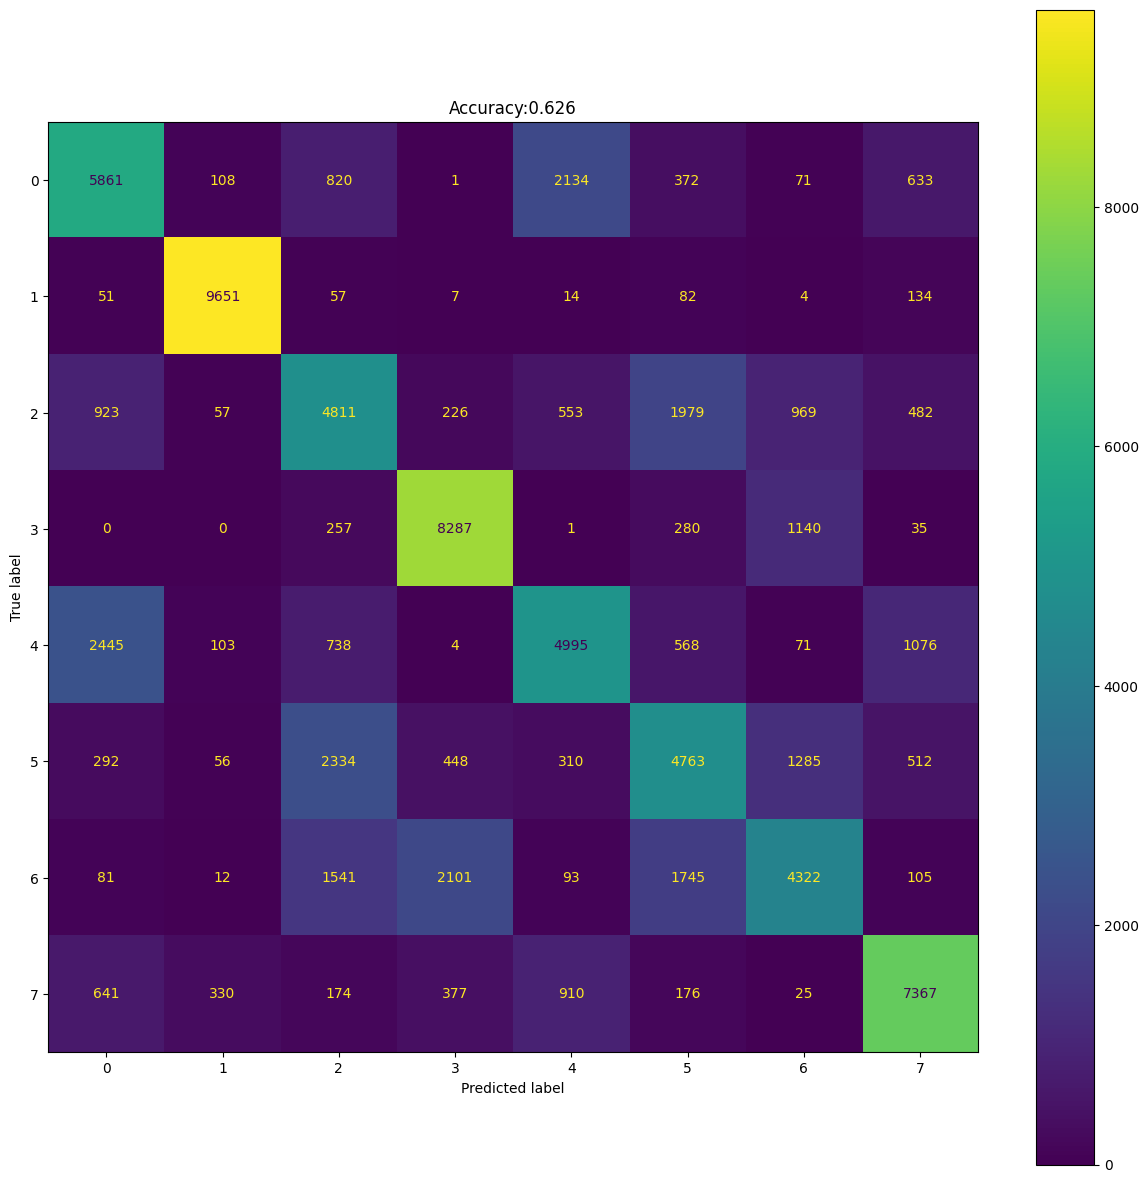

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-30(ii) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

2023-04-15 16:06:02.462660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 3.9458 - accuracy: 0.1612
test loss, test acc: [3.9457952976226807, 0.16117499768733978]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 5 2 ... 5 5 2]
0
[[ 676   56 2642  426  747 4978  333  142]
 [   3 1604 4777  832    5  258  354 2167]
 [ 315  111 1931  353  466 5954  725  145]
 [ 224  231  442   90   60 7886  992   75]
 [ 193   24 1546  484 1101 6302   60  290]
 [ 510   86 1836  253  339 6364  535   77]
 [ 271  154 1424  197  451 6796  568  139]
 [ 223  298  649 1549  127 4445 2149  560]]
              precision    recall  f1-score   support

           0       0.28      0.07      0.11     10000
           1       0.63      0.16      0.26     10000
           2       0.13      0.19      0.15     10000
           3       0.02      0.01      0.01     10000
           4       0.33      0.11      0.17     10000
           5       0.15      0.64      0.24     10000
           6       0.10      0.06      0.07     10000
           7       0.16      0.06      0.08     10000

    accuracy                           0.16     80000
   macro avg       0.22      0.16  

Test Accuracy:0.161175


Text(0.5, 1.0, 'Accuracy:0.161')

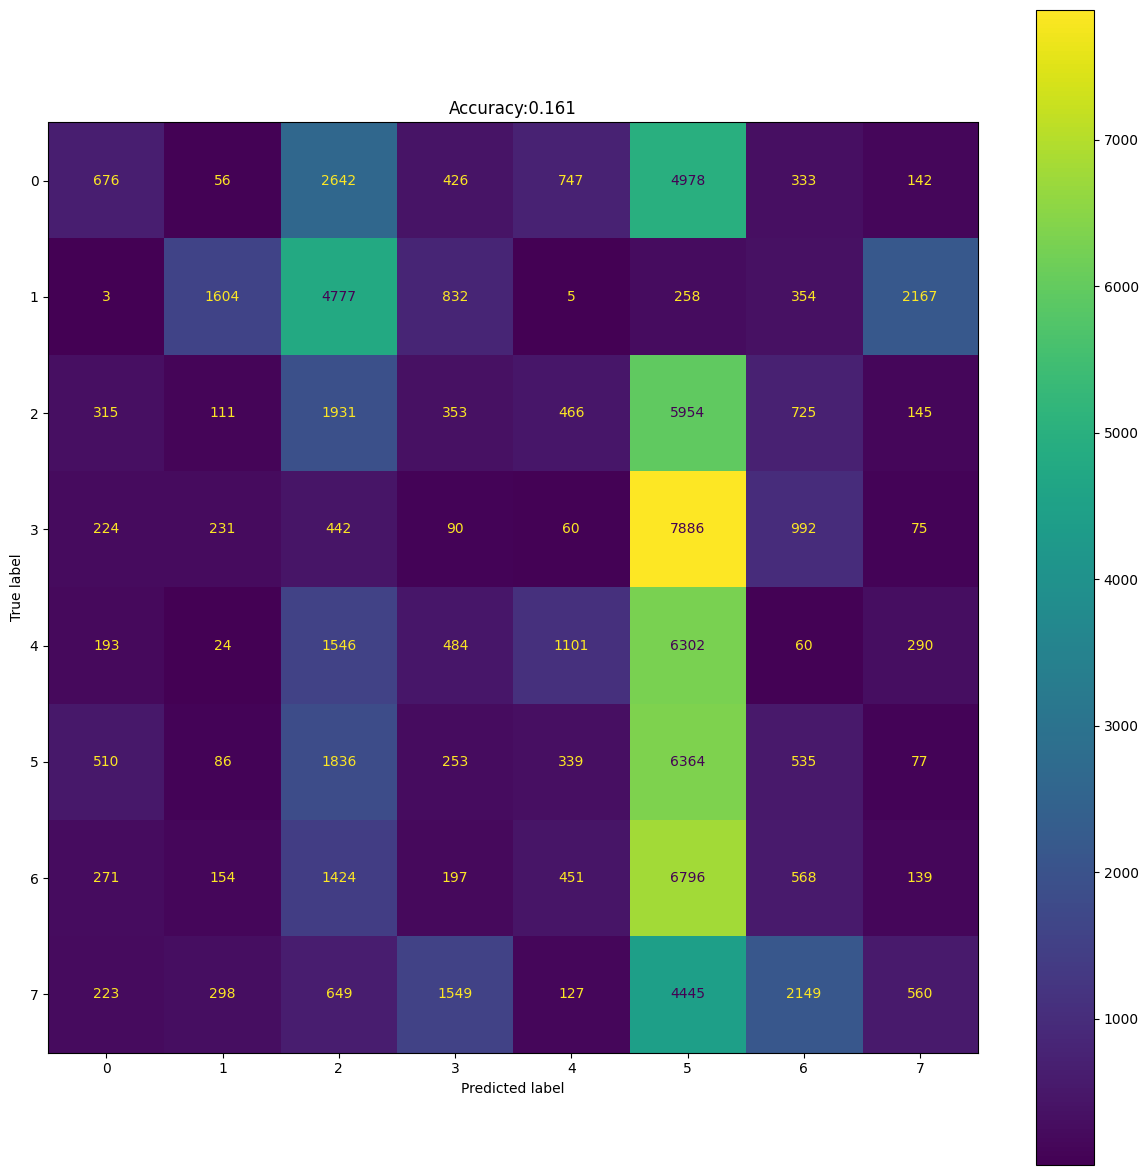

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(iii) model to Nordic Device-30(ii) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 4ms/step - loss: 2.6318 - accuracy: 0.2309
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8552 - accuracy: 0.3233
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6161 - accuracy: 0.3844
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5392 - accuracy: 0.4125
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.5045 - accuracy: 0.4295
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4833 - accuracy: 0.4390
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4680 - accuracy: 0.4473
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4555 - accuracy: 0.4525
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.4449 - accuracy: 0.4567
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss

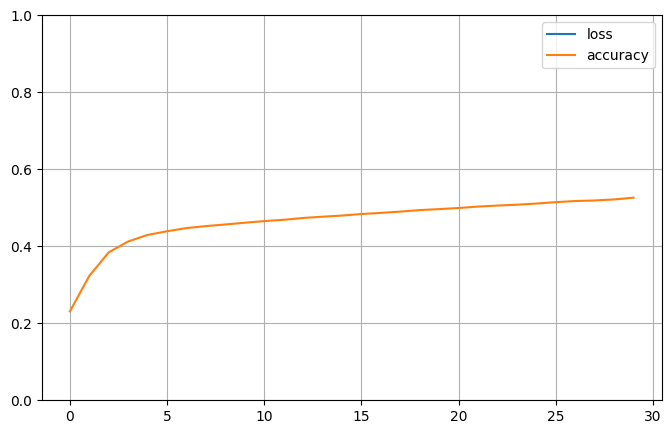

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.3041 - accuracy: 0.5252
test loss, test acc: [1.3041349649429321, 0.5251625180244446]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 0 0 ... 3 7 1]
5
[[4361  238  584  693 2131  964  458  571]
 [ 114 9234   17   66  114   14   36  405]
 [1314  250 2180 1123 1380 2065  742  946]
 [ 322  114  246 7192  293  578  419  836]
 [1422  178  516  371 6145  718  273  377]
 [1359  204  957 1227 1282 3606  660  705]
 [1182  197  764 1777 1195 1656 2498  731]
 [ 268  405  270 1275  405  382  198 6797]]
              precision    recall  f1-score   support

           0       0.42      0.44      0.43     10000
           1       0.85      0.92      0.89     10000
           2       0.39      0.22      0.28     10000
           3       0.52      0.72      0.61     10000
           4       0.47      0.61      0.54     10000
           5       0.36      0.36      0.36     10000
           6       0.47      0.25      0.33     10000
           7       0.60      0.68      0.64     10000

    accuracy                           0.53     80000
   macro avg       0.51      0.53  

Test Accuracy:0.5251625


Text(0.5, 1.0, 'Accuracy:0.525')

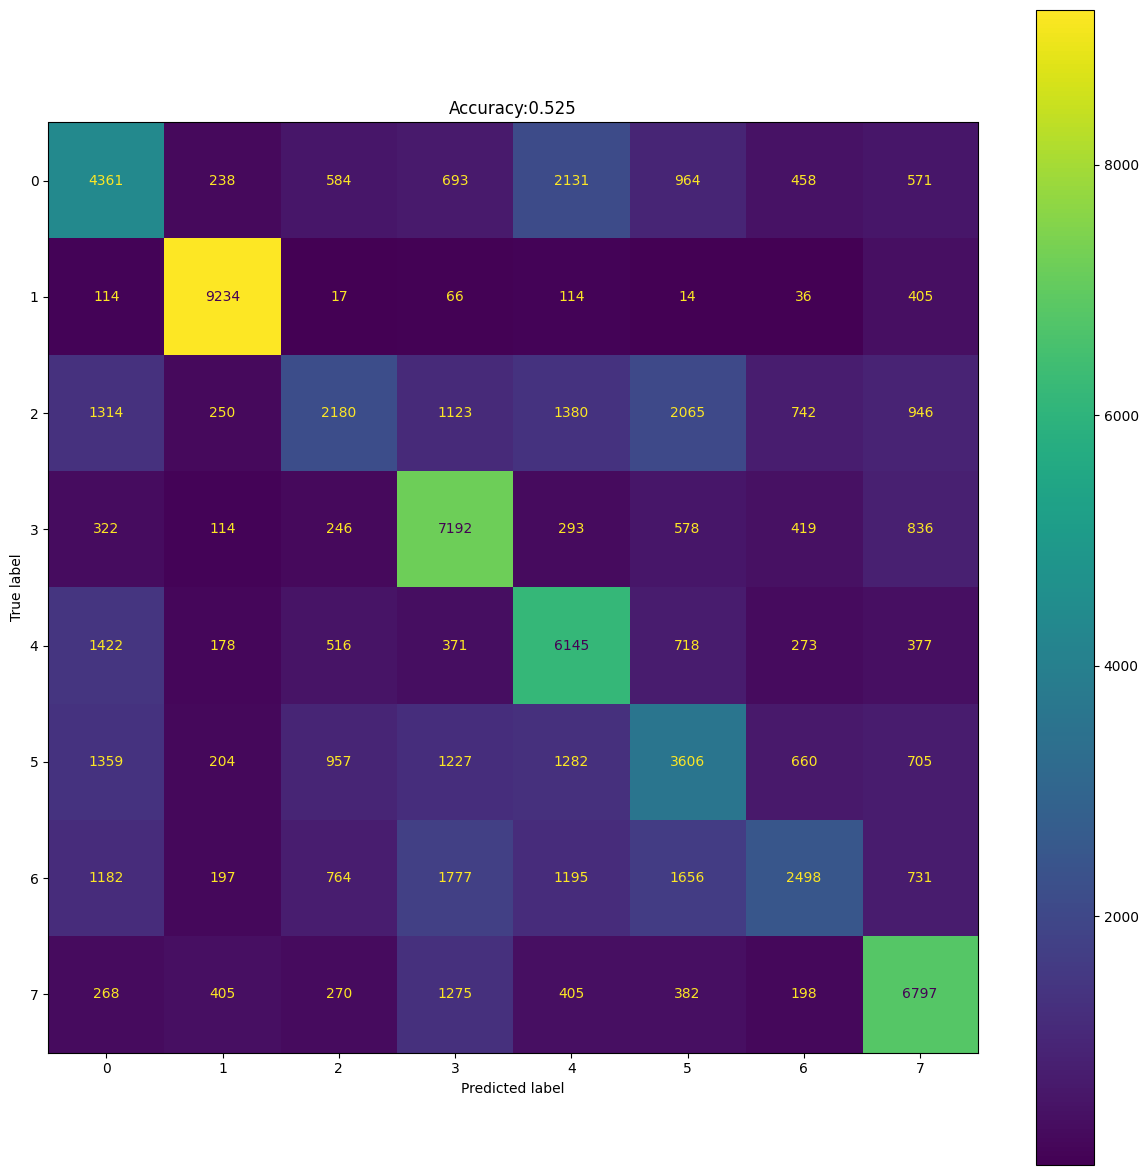

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iv) model to Nordic Device-30(ii) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 4.5672 - accuracy: 0.1296
test loss, test acc: [4.567239761352539, 0.12956249713897705]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[4 5 0 ... 5 0 5]
4
[[1694    0  239  236  853 6781   83  114]
 [2075   63  544  535    1 4967 1646  169]
 [1467   10  669  113  543 6549  503  146]
 [1316   66  903   63  422 6009 1062  159]
 [2083    0  147  361  290 7033   33   53]
 [1162    9  828  130  722 6739  271  139]
 [1333   11  325  107  651 7138  333  102]
 [2579    1  115  127   73 5520 1071  514]]
              precision    recall  f1-score   support

           0       0.12      0.17      0.14     10000
           1       0.39      0.01      0.01     10000
           2       0.18      0.07      0.10     10000
           3       0.04      0.01      0.01     10000
           4       0.08      0.03      0.04     10000
           5       0.13      0.67      0.22     10000
           6       0.07      0.03      0.04     10000
           7       0.37      0.05      0.09     10000

    accuracy                           0.13     80000
   macro avg       0.17      0.13  

Test Accuracy:0.1295625


Text(0.5, 1.0, 'Accuracy:0.130')

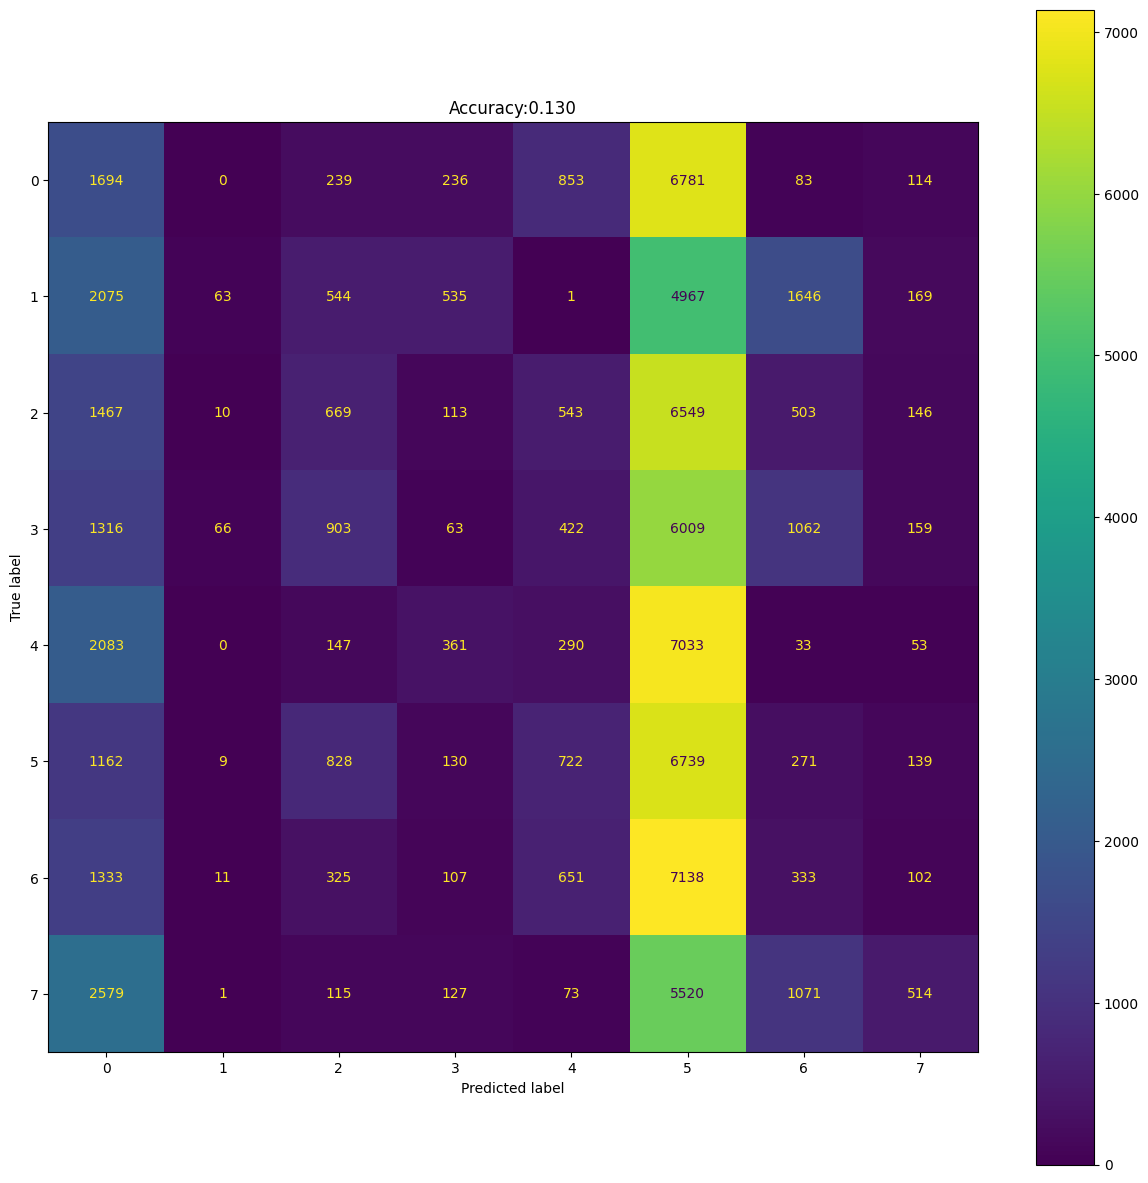

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8207 - accuracy: 0.1866
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9426 - accuracy: 0.2787
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.6791 - accuracy: 0.3491
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5981 - accuracy: 0.3811
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.5623 - accuracy: 0.3973
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5406 - accuracy: 0.4083
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5251 - accuracy: 0.4140
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.5125 - accuracy: 0.4204
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5016 - accuracy: 0.4262
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss

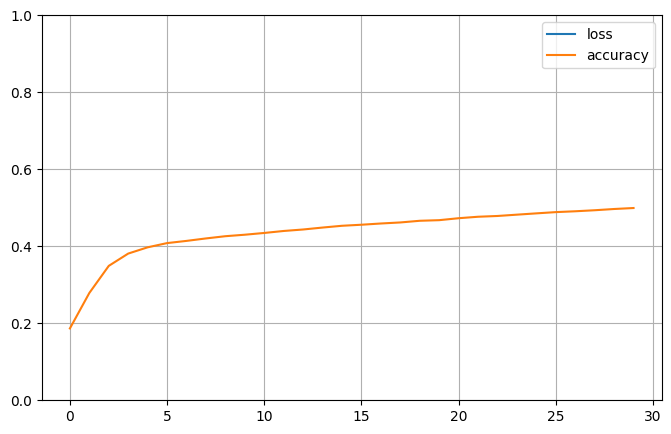

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 1.3579 - accuracy: 0.5017
test loss, test acc: [1.3578612804412842, 0.5017125010490417]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 5 0 ... 2 7 1]
5
[[3450   84  847  466 3191  837  655  470]
 [   5 8654   34  423  122   37   63  662]
 [ 727  329 3290 2032  930 1165  759  768]
 [ 211  567  515 6108  328  892  611  768]
 [1180  155  718  240 6398  417  360  532]
 [ 990  217 1345 2123  990 2867 1007  461]
 [ 996  199 1286 1890 1220 1359 2299  751]
 [ 101  738  446  667  679   72  226 7071]]
              precision    recall  f1-score   support

           0       0.45      0.34      0.39     10000
           1       0.79      0.87      0.83     10000
           2       0.39      0.33      0.36     10000
           3       0.44      0.61      0.51     10000
           4       0.46      0.64      0.54     10000
           5       0.37      0.29      0.32     10000
           6       0.38      0.23      0.29     10000
           7       0.62      0.71      0.66     10000

    accuracy                           0.50     80000
   macro avg       0.49      0.50  

Test Accuracy:0.5017125


Text(0.5, 1.0, 'Accuracy:0.502')

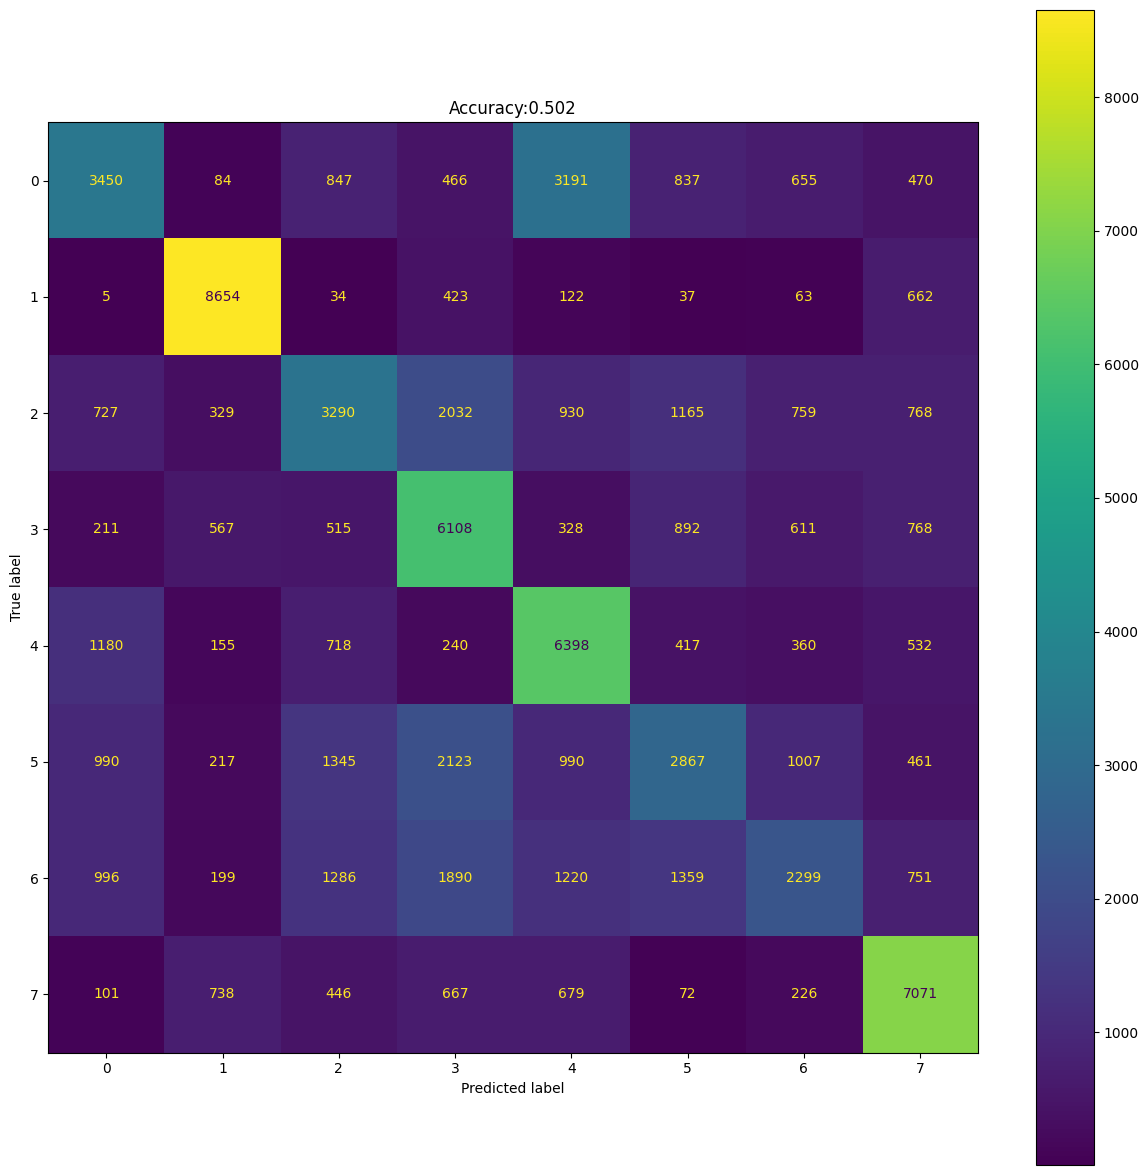

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(v) model to Nordic Device-30(ii) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 4.5462 - accuracy: 0.1519
test loss, test acc: [4.546158313751221, 0.15193749964237213]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[4 5 5 ... 2 5 5]
4
[[1165    0  414   88 1275 7043   11    4]
 [  30  373 1808 1545  203 5800   79  162]
 [ 238    2 1164  185  485 7869   48    9]
 [  61   56  864  175  580 7995  111  158]
 [ 846    1  236  108  804 7998    5    2]
 [ 173   18  926  208  442 8177   37   19]
 [  84    5  652  179  582 8404   15   79]
 [  13   67 1684  792  309 6798   55  282]]
              precision    recall  f1-score   support

           0       0.45      0.12      0.18     10000
           1       0.71      0.04      0.07     10000
           2       0.15      0.12      0.13     10000
           3       0.05      0.02      0.03     10000
           4       0.17      0.08      0.11     10000
           5       0.14      0.82      0.23     10000
           6       0.04      0.00      0.00     10000
           7       0.39      0.03      0.05     10000

    accuracy                           0.15     80000
   macro avg       0.26      0.15  

Test Accuracy:0.1519375


Text(0.5, 1.0, 'Accuracy:0.152')

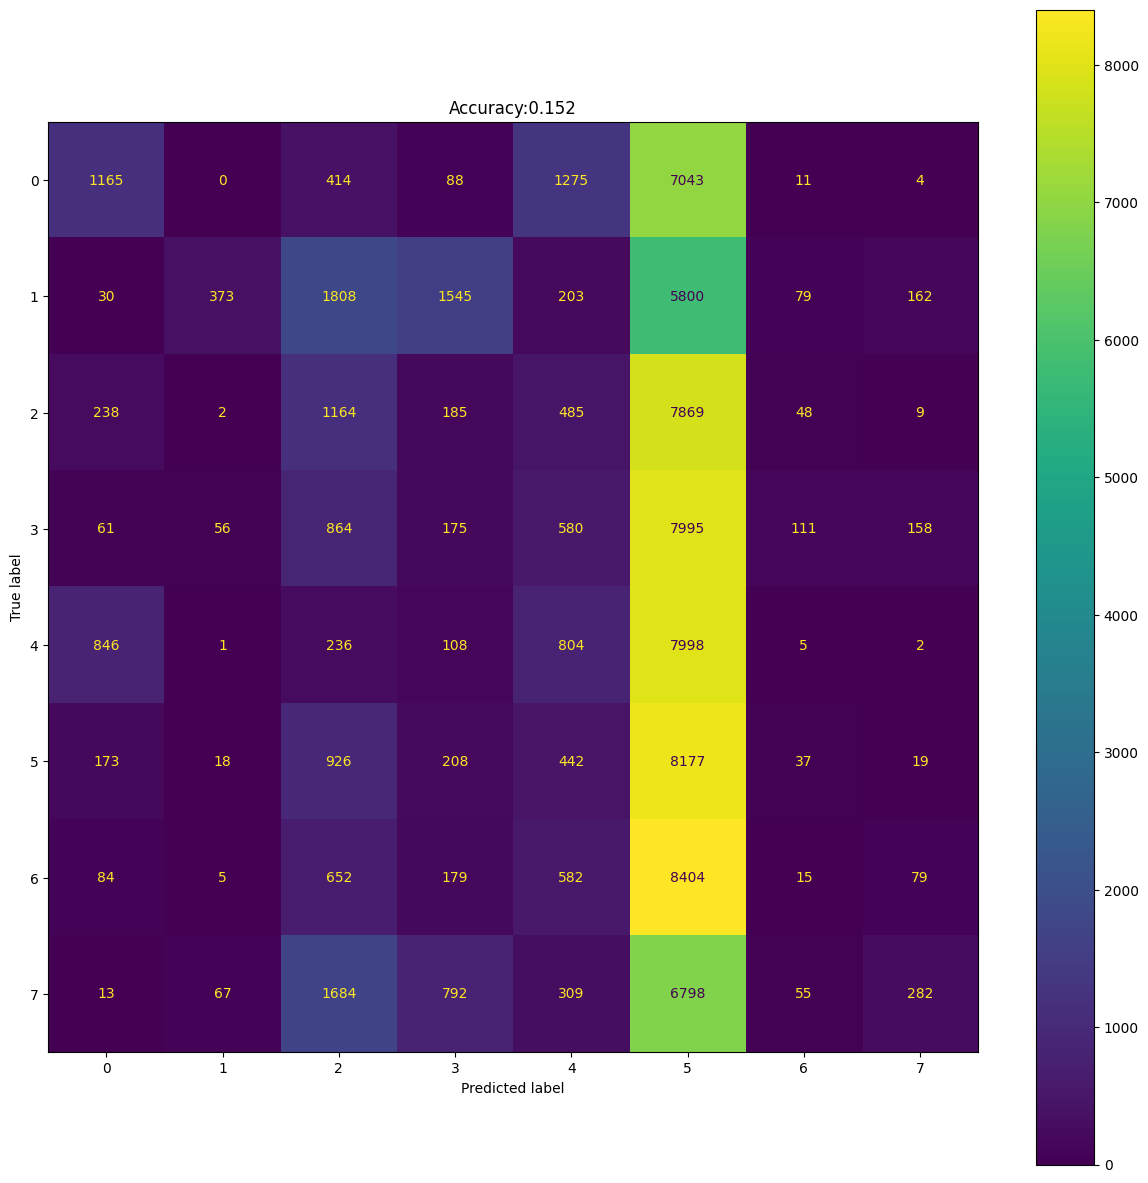

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(v) model to Nordic Device-30(ii) dataset 

In [30]:
model = keras.models.load_model("//Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.6295 - accuracy: 0.2170
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9725 - accuracy: 0.2591
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.7763 - accuracy: 0.3034
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7008 - accuracy: 0.3386
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.6572 - accuracy: 0.3625
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.6249 - accuracy: 0.3824
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5988 - accuracy: 0.3972
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5763 - accuracy: 0.4123
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5568 - accuracy: 0.4216
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss

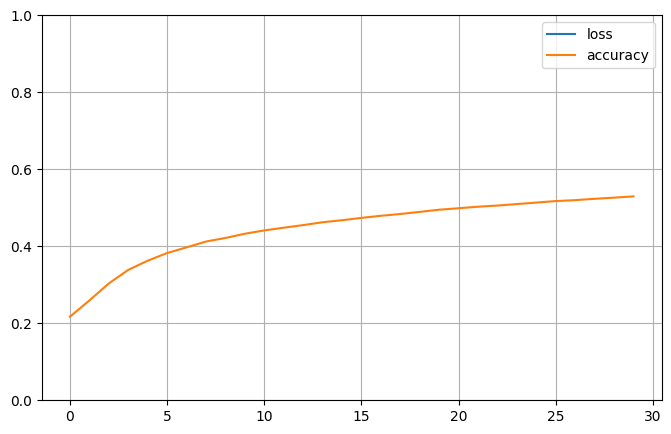

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [36]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.3379 - accuracy: 0.5255
test loss, test acc: [1.3379476070404053, 0.52548748254776]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 2 4 ... 7 2 7]
0
[[4802   59 1511  405 2372  398  272  181]
 [  51 9200   95   68  137    3   57  389]
 [ 910  366 4096 1254 1147 1042  561  624]
 [ 303  364 1025 6480  250  357  415  806]
 [1260  133 1169  202 6237  557  189  253]
 [ 655  427 2829 1656 1113 2269  537  514]
 [ 668  341 2214 2162  654  761 2036 1164]
 [ 266  443  582  996  487  118  189 6919]]
              precision    recall  f1-score   support

           0       0.54      0.48      0.51     10000
           1       0.81      0.92      0.86     10000
           2       0.30      0.41      0.35     10000
           3       0.49      0.65      0.56     10000
           4       0.50      0.62      0.56     10000
           5       0.41      0.23      0.29     10000
           6       0.48      0.20      0.29     10000
           7       0.64      0.69      0.66     10000

    accuracy                           0.53     80000
   macro avg       0.52      0.53  

Test Accuracy:0.5254875


Text(0.5, 1.0, 'Accuracy:0.525')

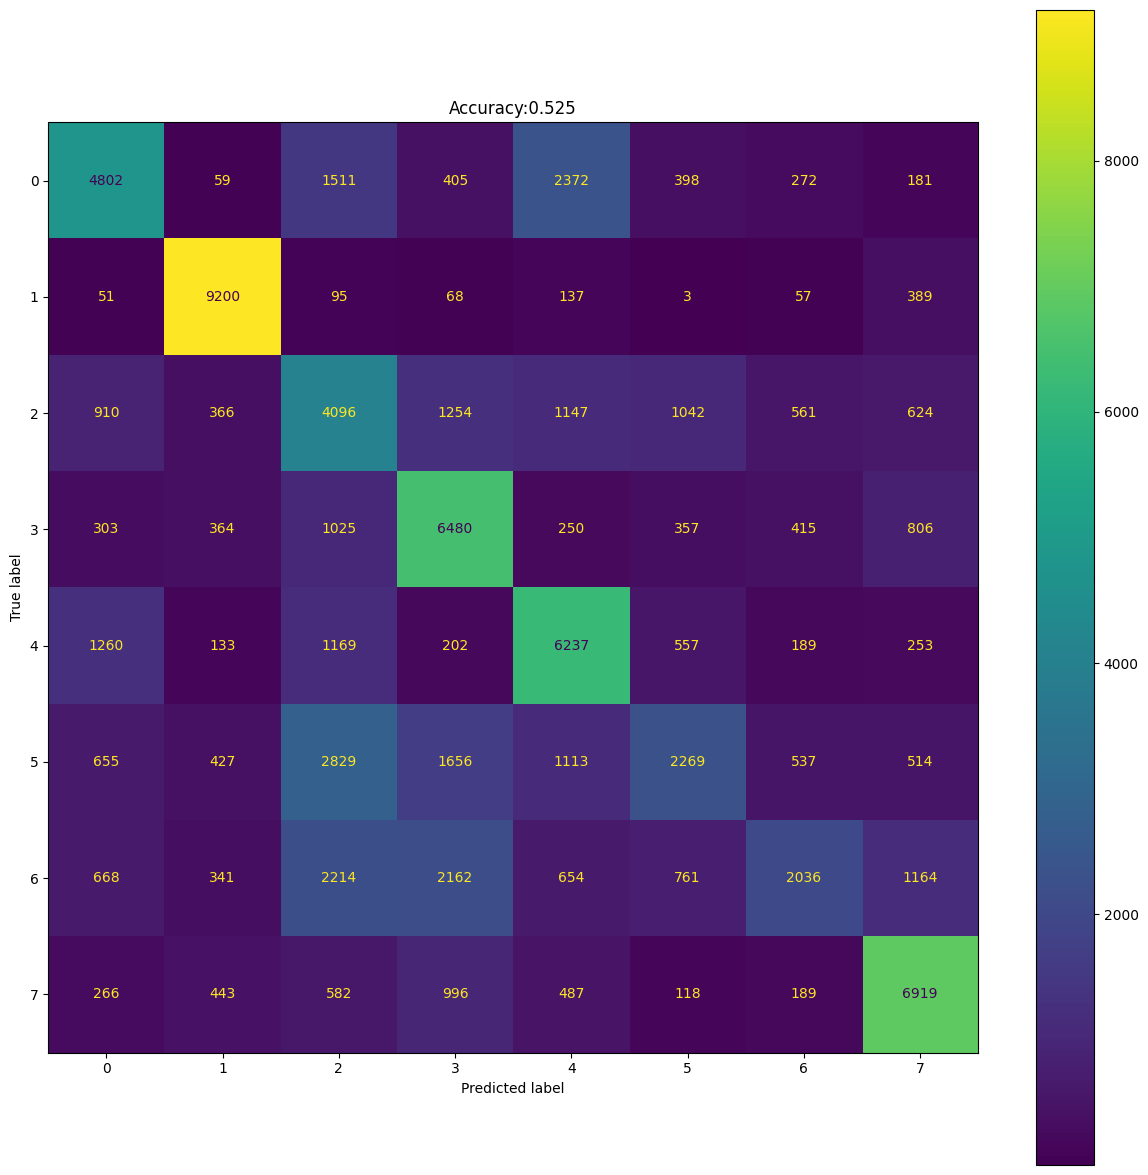

In [37]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Smae Device Other set of Models

Nordic Device-30(i) model to Nordic Device-30(ii) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.7841 - accuracy: 0.7495
test loss, test acc: [0.7841344475746155, 0.7494624853134155]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 4 0 ... 7 7 7]
5
[[3054    0   63    0 4687 2163   33    0]
 [   0 9963   30    1    0    0    0    6]
 [   0    0 7040   22    0  760 2178    0]
 [   0    0    0 9976    0    0   24    0]
 [ 139    0    3    0 9853    4    1    0]
 [   3    0 4500   46    0 1303 4148    0]
 [   0    0  780   59    0  167 8994    0]
 [   0   19   24  163    0    0   20 9774]]
              precision    recall  f1-score   support

           0       0.96      0.31      0.46     10000
           1       1.00      1.00      1.00     10000
           2       0.57      0.70      0.63     10000
           3       0.97      1.00      0.98     10000
           4       0.68      0.99      0.80     10000
           5       0.30      0.13      0.18     10000
           6       0.58      0.90      0.71     10000
           7       1.00      0.98      0.99     10000

    accuracy                           0.75     80000
   macro avg       0.76      0.75  

Test Accuracy:0.7494625


Text(0.5, 1.0, 'Accuracy:0.749')

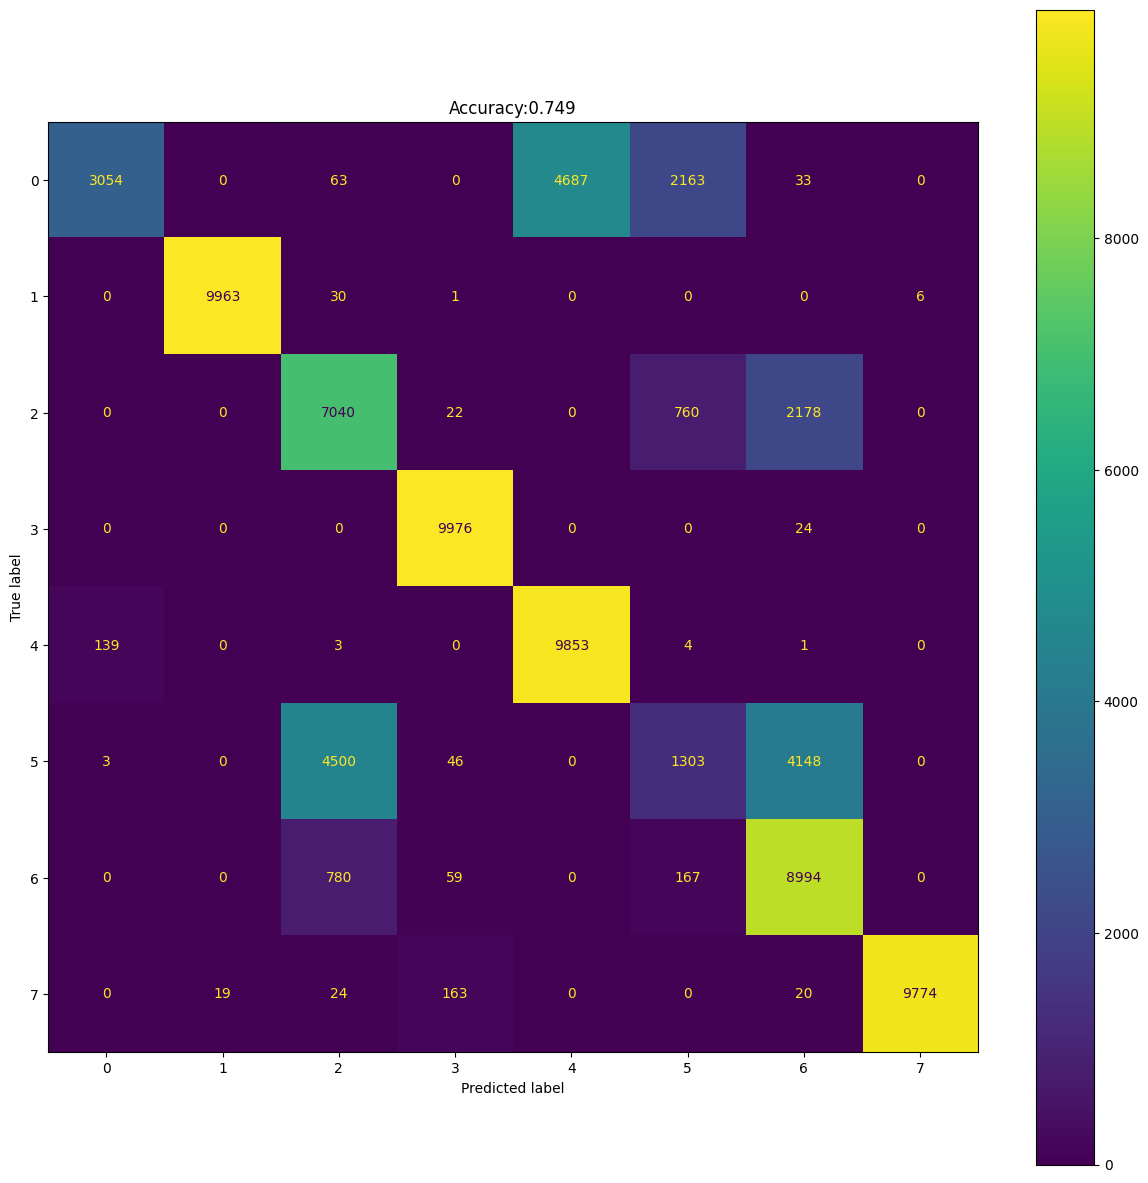

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other set of samples

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4790 - accuracy: 0.8084
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.4241 - accuracy: 0.8219
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3953 - accuracy: 0.8298
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3768 - accuracy: 0.8357
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3644 - accuracy: 0.8400
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3559 - accuracy: 0.8429
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3500 - accuracy: 0.8453
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3459 - accuracy: 0.8478
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.3426 - accuracy: 0.8492
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.33

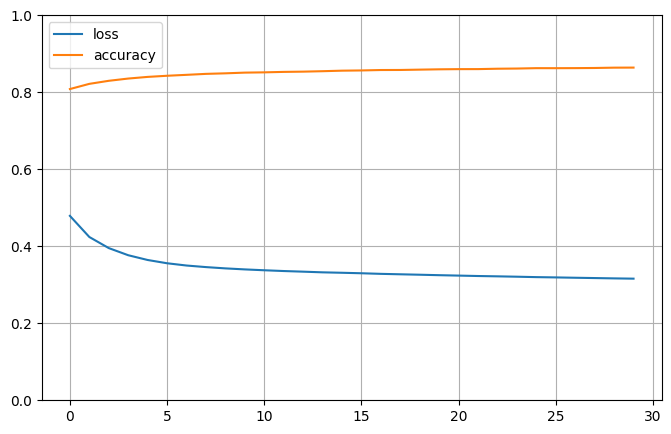

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 9s 4ms/step - loss: 0.3148 - accuracy: 0.8655
test loss, test acc: [0.314848393201828, 0.8654999732971191]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 0 0 ... 7 7 7]
0
[[9473    0   13    0  512    2    0    0]
 [   0 9975   15    0    0    0    0   10]
 [   3    0 7221    4    0 2028  741    3]
 [   0    0    0 9974    0    0   18    8]
 [ 401    0    0    0 9599    0    0    0]
 [  24    0 3523    4    0 4802 1646    1]
 [   0    0  641    5    0 1119 8222   13]
 [   0    9    9    4    0    0    4 9974]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     10000
           1       1.00      1.00      1.00     10000
           2       0.63      0.72      0.67     10000
           3       1.00      1.00      1.00     10000
           4       0.95      0.96      0.95     10000
           5       0.60      0.48      0.54     10000
           6       0.77      0.82      0.80     10000
           7       1.00      1.00      1.00     10000

    accuracy                           0.87     80000
   macro avg       0.86      0.87  

Test Accuracy:0.8655


Text(0.5, 1.0, 'Accuracy:0.866')

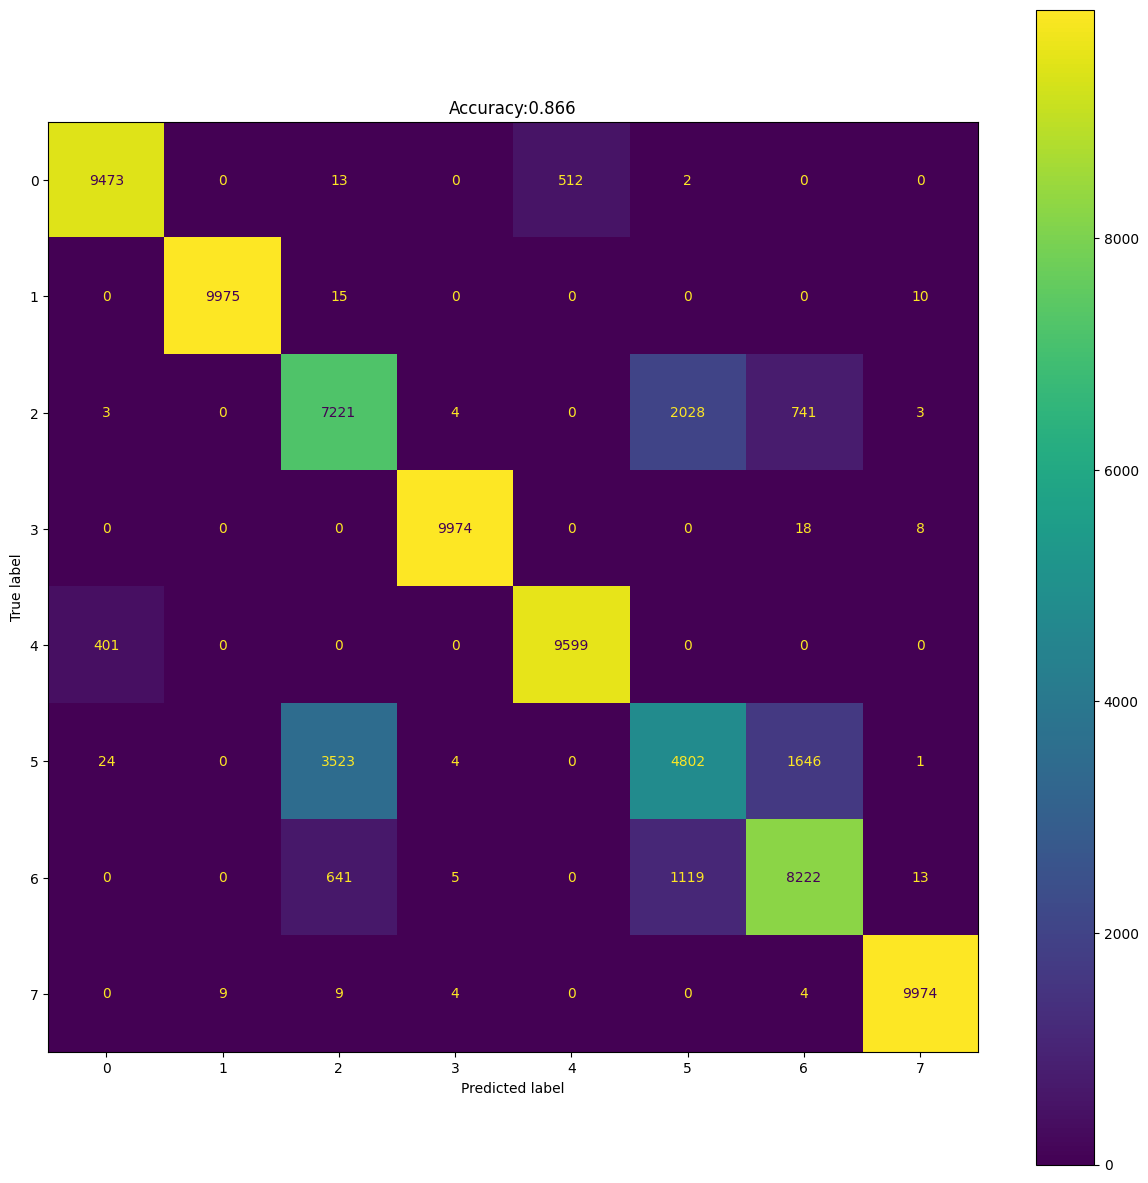

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-30(ii) dataset 

In [38]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [39]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 4.2605 - accuracy: 0.1408
test loss, test acc: [4.260505199432373, 0.14083750545978546]


In [40]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 4 5 ... 2 2 2]
5
[[   3    0 1578  449 1265 5516   36 1153]
 [   0   27 1065  158 6557 1919  271    3]
 [  26    7 1990  417 1769 5148  147  496]
 [  21    6 1873  512 3774 3120  609   85]
 [   4    0  372  502 1340 7337   24  421]
 [  11    7 1382  224 1214 6921   96  145]
 [  30    7 2698  642 1572 4366  242  443]
 [  14   12 2293  388 3048 3582  431  232]]
              precision    recall  f1-score   support

           0       0.03      0.00      0.00     10000
           1       0.41      0.00      0.01     10000
           2       0.15      0.20      0.17     10000
           3       0.16      0.05      0.08     10000
           4       0.07      0.13      0.09     10000
           5       0.18      0.69      0.29     10000
           6       0.13      0.02      0.04     10000
           7       0.08      0.02      0.04     10000

    accuracy                           0.14     80000
   macro avg       0.15      0.14  

Test Accuracy:0.1408375


Text(0.5, 1.0, 'Accuracy:0.141')

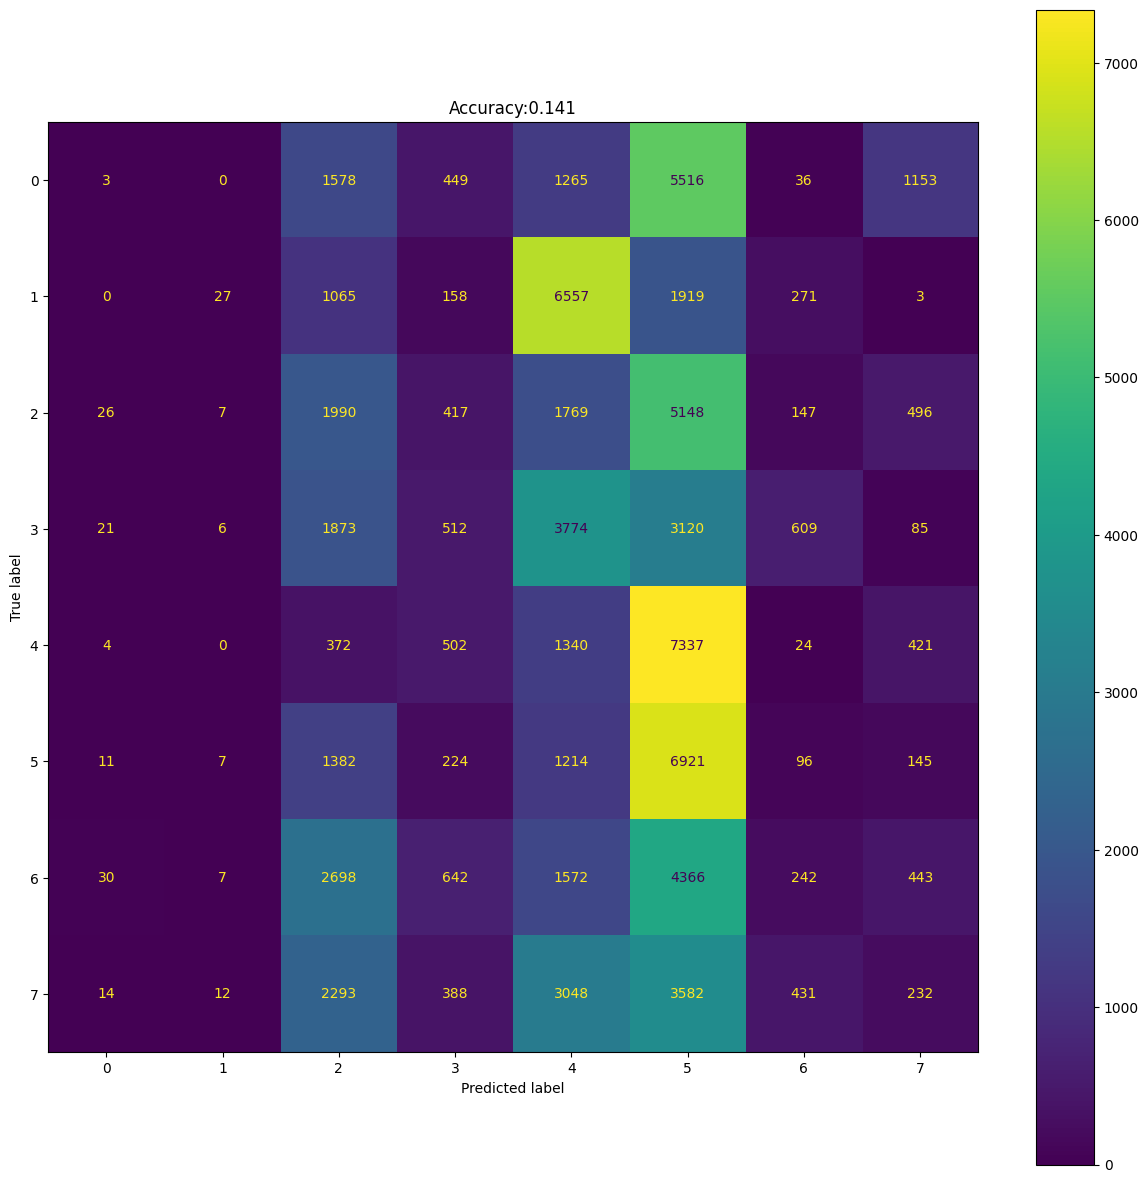

In [41]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [42]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [43]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [44]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.6606 - accuracy: 0.2014
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8864 - accuracy: 0.3122
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.6210 - accuracy: 0.3825
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.5166 - accuracy: 0.4220
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.4626 - accuracy: 0.4460
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.4276 - accuracy: 0.4618
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4021 - accuracy: 0.4716
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3818 - accuracy: 0.4807
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3651 - accuracy: 0.4886
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1

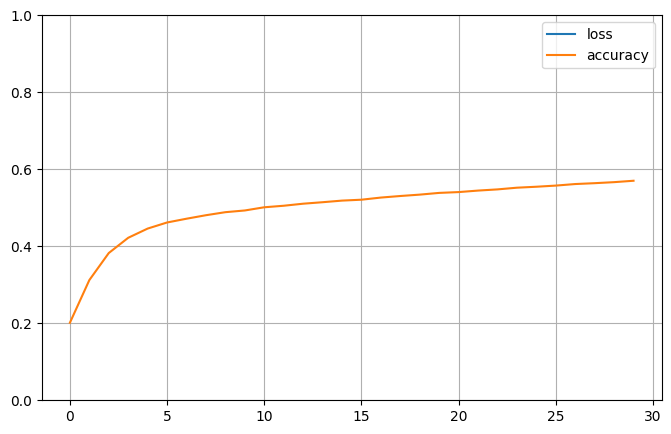

In [45]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [46]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.1953 - accuracy: 0.5767
test loss, test acc: [1.195281982421875, 0.5767499804496765]


In [47]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 4 5 ... 6 6 7]
7
[[4970   33  615  453 2437  606  671  215]
 [  16 9864   12    2   38   22   23   23]
 [ 962   48 4001 1061  578 1626 1373  351]
 [ 271   90  453 7150  360  480  424  772]
 [1468   64  191  369 7092  487  244   85]
 [ 750  120 1973 1082 1068 3879  879  249]
 [ 846   55 1726 1184  490 1017 4071  611]
 [ 419  296  614 1752  531  460  815 5113]]
              precision    recall  f1-score   support

           0       0.51      0.50      0.50     10000
           1       0.93      0.99      0.96     10000
           2       0.42      0.40      0.41     10000
           3       0.55      0.71      0.62     10000
           4       0.56      0.71      0.63     10000
           5       0.45      0.39      0.42     10000
           6       0.48      0.41      0.44     10000
           7       0.69      0.51      0.59     10000

    accuracy                           0.58     80000
   macro avg       0.57      0.58  

Test Accuracy:0.57675


Text(0.5, 1.0, 'Accuracy:0.577')

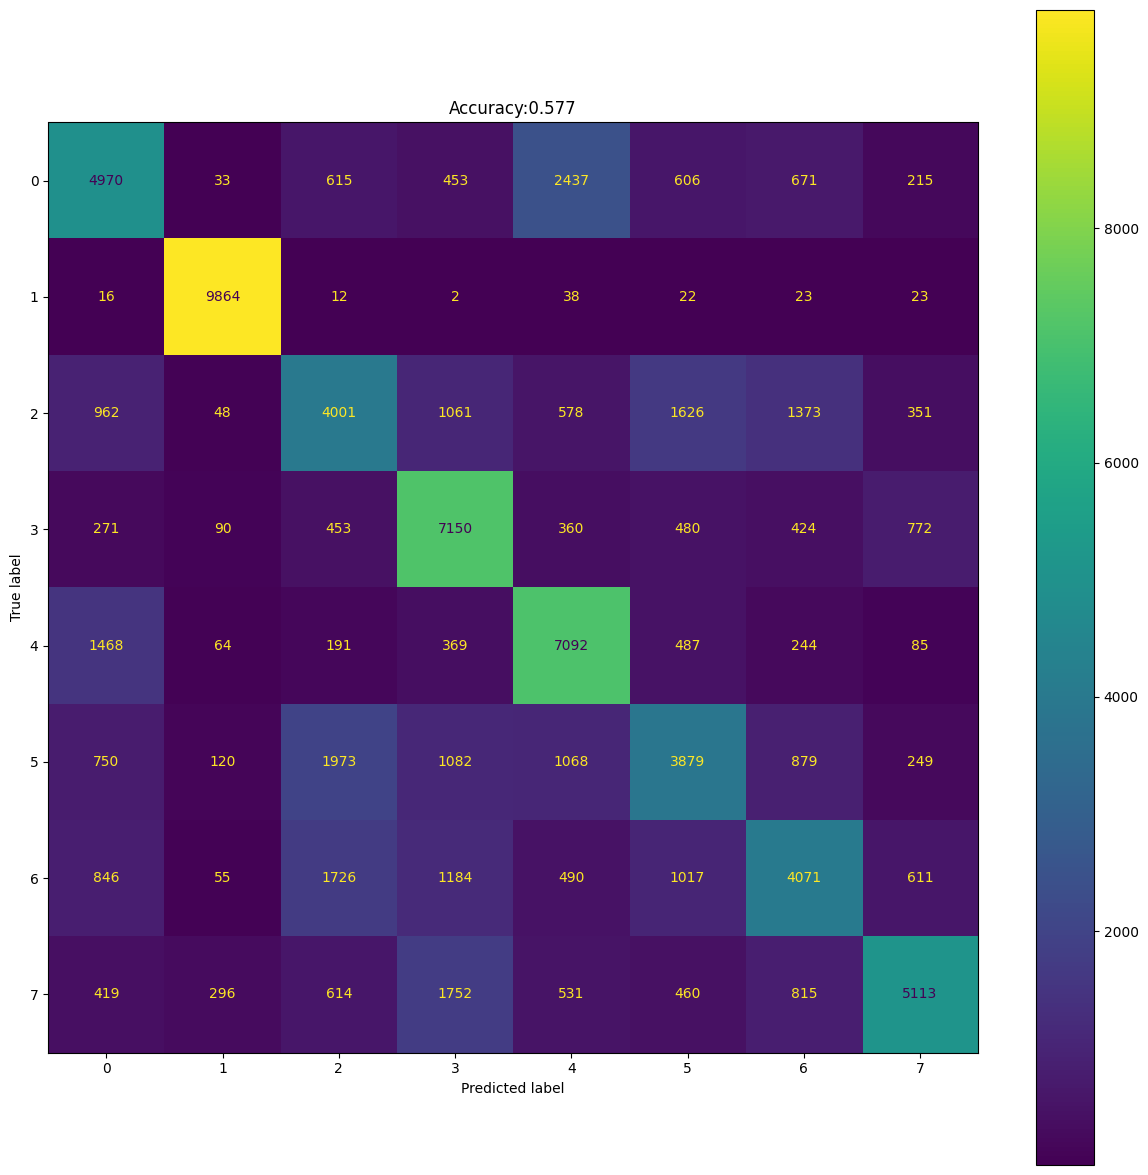

In [48]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iv) model to Nordic Device-30(ii) dataset 

In [49]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")

In [50]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 12s 5ms/step - loss: 5.9456 - accuracy: 0.1342
test loss, test acc: [5.945583820343018, 0.13421249389648438]


In [51]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 0 5 ... 5 0 5]
5
[[2502    0  129   27    0 7340    2    0]
 [ 186    0   62    3   20 9705   23    1]
 [1677    0  346   18    0 7955    4    0]
 [3922    0 1823    2    0 4231   22    0]
 [3351    0   92    7    0 6550    0    0]
 [1999    0  328   18    0 7651    4    0]
 [ 728    0  757   15    0 8463   36    1]
 [1689    0  109   10   14 7883   95  200]]
              precision    recall  f1-score   support

           0       0.16      0.25      0.19     10000
           1       0.00      0.00      0.00     10000
           2       0.09      0.03      0.05     10000
           3       0.02      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.13      0.77      0.22     10000
           6       0.19      0.00      0.01     10000
           7       0.99      0.02      0.04     10000

    accuracy                           0.13     80000
   macro avg       0.20      0.13  

Test Accuracy:0.1342125


Text(0.5, 1.0, 'Accuracy:0.134')

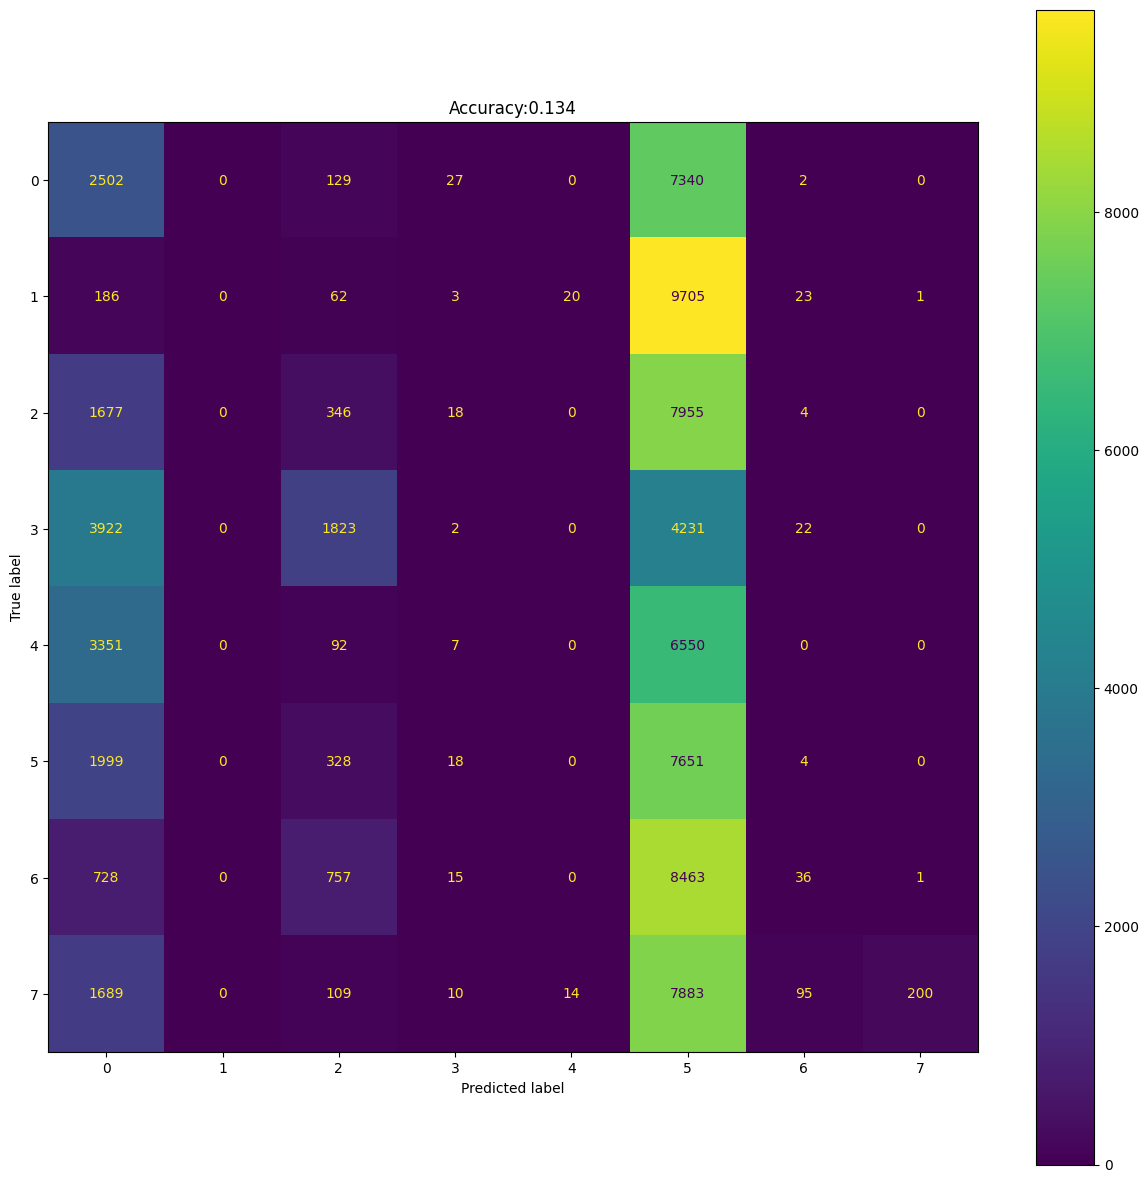

In [52]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [53]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [54]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [55]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.5668 - accuracy: 0.1955
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8202 - accuracy: 0.3192
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6202 - accuracy: 0.3859
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5238 - accuracy: 0.4226
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4605 - accuracy: 0.4484
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4136 - accuracy: 0.4663
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3757 - accuracy: 0.4815
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3442 - accuracy: 0.4952
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3177 - accuracy: 0.5075
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

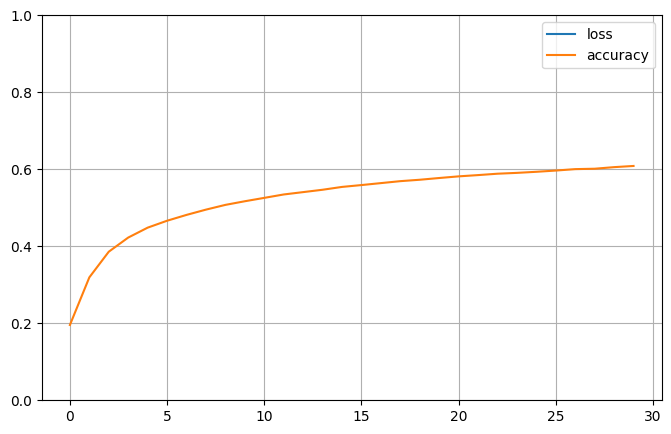

In [56]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [57]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.0841 - accuracy: 0.6094
test loss, test acc: [1.0840519666671753, 0.609375]


In [58]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[1 0 4 ... 7 7 7]
1
[[4978    4  729  433 2437  229  577  613]
 [   1 9863   11   11   30    0   14   70]
 [ 956    2 4640 1103  532  866 1527  374]
 [ 249    0  557 7772  265  200  752  205]
 [1784    4  398  336 6624  170  284  400]
 [1007    2 3304 1096  628 2223 1389  351]
 [ 714    7 1598 1272  306  350 5128  625]
 [ 243  214  191  536  735   96  463 7522]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     10000
           1       0.98      0.99      0.98     10000
           2       0.41      0.46      0.43     10000
           3       0.62      0.78      0.69     10000
           4       0.57      0.66      0.61     10000
           5       0.54      0.22      0.31     10000
           6       0.51      0.51      0.51     10000
           7       0.74      0.75      0.75     10000

    accuracy                           0.61     80000
   macro avg       0.61      0.61  

Test Accuracy:0.609375


Text(0.5, 1.0, 'Accuracy:0.609')

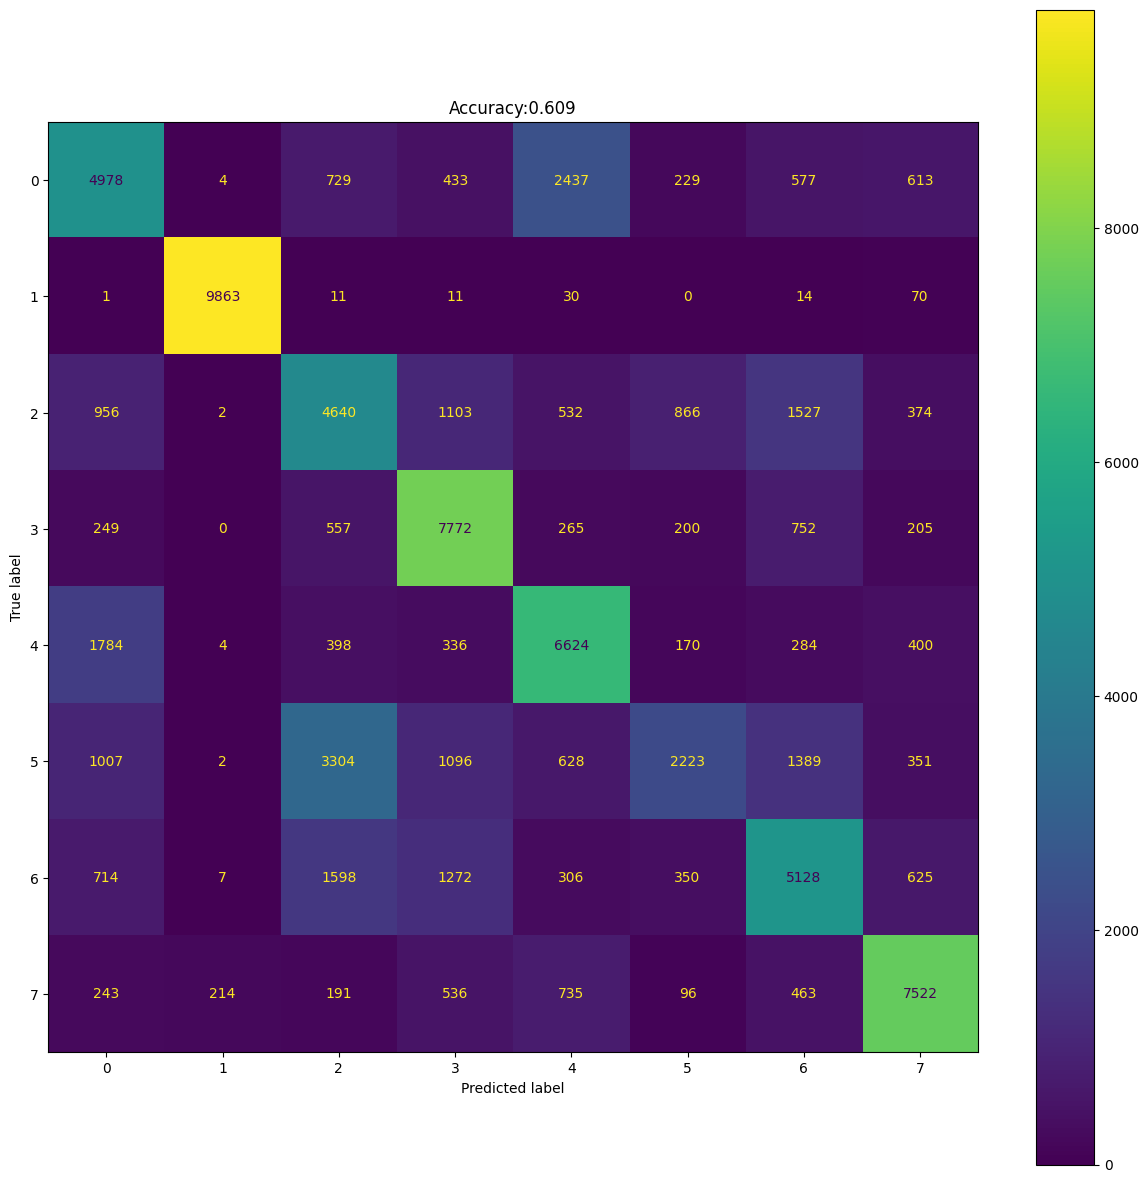

In [59]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(v) model to Nordic Device-30(ii) dataset 

In [60]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")

In [61]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 5.6417 - accuracy: 0.1364
test loss, test acc: [5.641693592071533, 0.13644999265670776]


In [62]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 5 5 ... 5 0 0]
5
[[4867    0  255  270    0 4547    0   61]
 [6127  124   74 1239  175 1933  326    2]
 [5055    1  240  143    0 4549    4    8]
 [6531    0  620   12    0 2780   57    0]
 [5266    0  417  401    0 3874    2   40]
 [4074    1  220   90    0 5607    4    4]
 [3369    1  531  191    0 5891   13    4]
 [4332    2  733  135    0 4694   51   53]]
              precision    recall  f1-score   support

           0       0.12      0.49      0.20     10000
           1       0.96      0.01      0.02     10000
           2       0.08      0.02      0.04     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.17      0.56      0.26     10000
           6       0.03      0.00      0.00     10000
           7       0.31      0.01      0.01     10000

    accuracy                           0.14     80000
   macro avg       0.21      0.14  

Test Accuracy:0.13645


Text(0.5, 1.0, 'Accuracy:0.136')

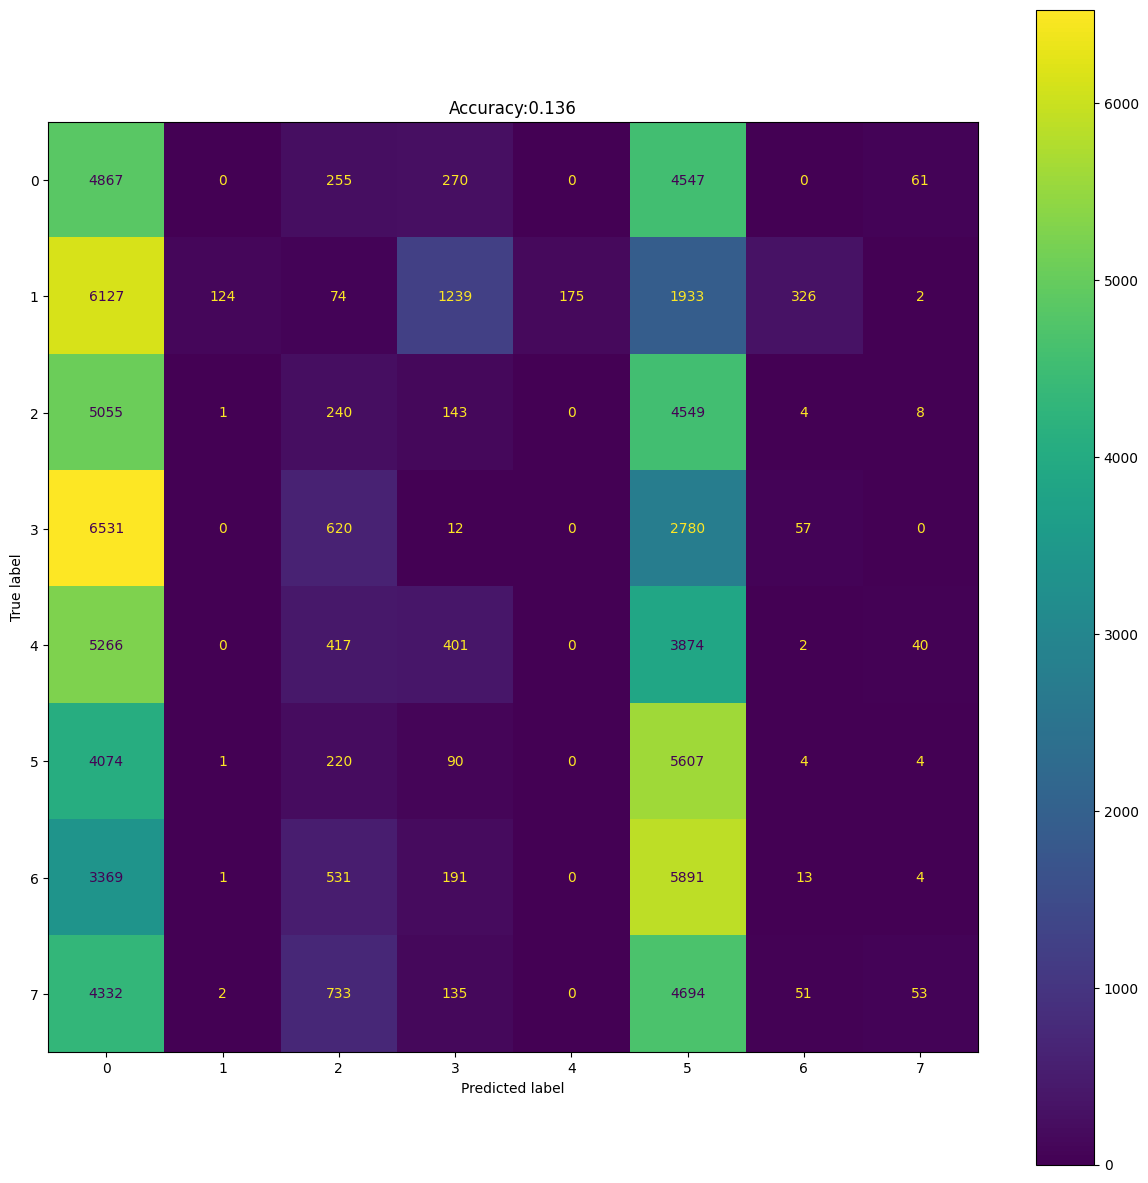

In [63]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')



## Cross-model Validation by applying Transfer Learning of other Device's Model

In [64]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [65]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [66]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.8118 - accuracy: 0.1567
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8867 - accuracy: 0.2996
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6115 - accuracy: 0.3770
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.4941 - accuracy: 0.4178
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4297 - accuracy: 0.4490
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.3882 - accuracy: 0.4720
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.3583 - accuracy: 0.4898
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.3348 - accuracy: 0.5012
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.3153 - accuracy: 0.5112
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss:

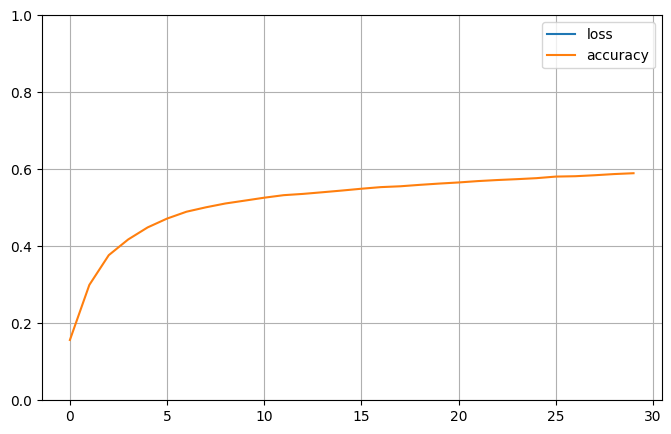

In [67]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [68]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.1281 - accuracy: 0.5902
test loss, test acc: [1.1281431913375854, 0.5901625156402588]


In [69]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[0 0 4 ... 7 1 1]
0
[[6215    9  233  465 1817  431  713  117]
 [   1 9777    1    3    3    1    4  210]
 [ 832   30 2542 1218  516 2741 1913  208]
 [ 273    9  328 7385  320  622  726  337]
 [2299    6  282  577 5407  457  855  117]
 [ 680   15 1355 1265  484 4309 1723  169]
 [ 827   50  703 1161  856 1414 4492  497]
 [ 719  414   74  802  341   93  471 7086]]
              precision    recall  f1-score   support

           0       0.52      0.62      0.57     10000
           1       0.95      0.98      0.96     10000
           2       0.46      0.25      0.33     10000
           3       0.57      0.74      0.65     10000
           4       0.55      0.54      0.55     10000
           5       0.43      0.43      0.43     10000
           6       0.41      0.45      0.43     10000
           7       0.81      0.71      0.76     10000

    accuracy                           0.59     80000
   macro avg       0.59      0.59  

Test Accuracy:0.5901625


Text(0.5, 1.0, 'Accuracy:0.590')

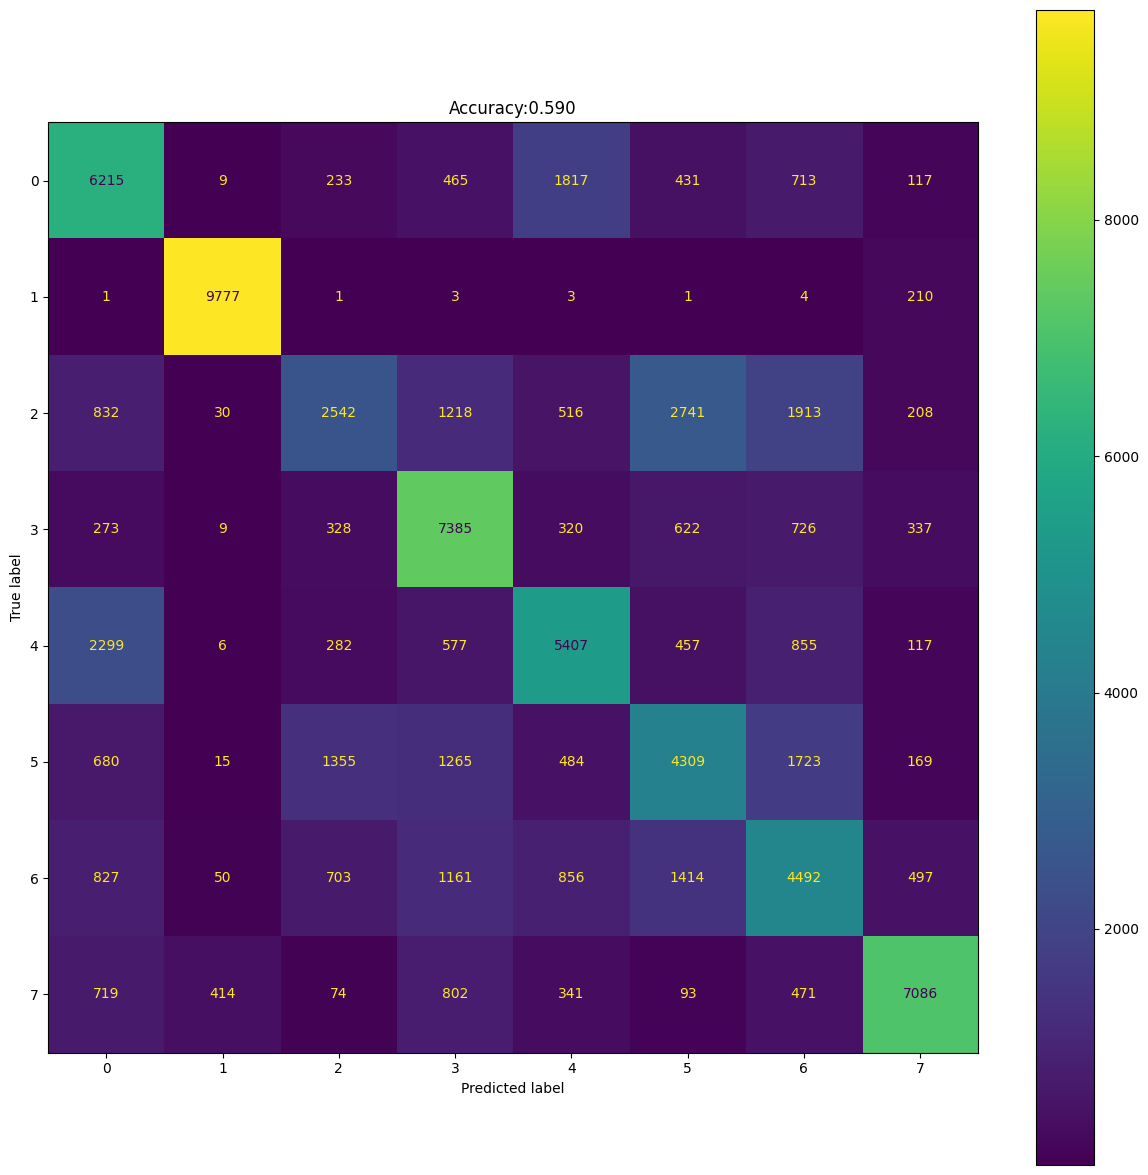

In [70]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')